In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

/home/enf/software/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%matplotlib inline



In [3]:
from sklearn.preprocessing import scale

In [4]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [5]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import scale
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [7]:

ori_feature_name = copy.deepcopy(feature_name)

In [8]:
#schemes = ["closest-heavy", "CA"]
#feature_name = "%s-CA" %ori_feature_name

In [9]:
rho = 0.01
rho_string = "_rho0pt01"

In [10]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A
/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A


In [11]:
from sklearn.metrics import roc_curve, auc

In [12]:
tica_dir

'/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01'

In [ ]:
cutoff

In [11]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, 
                          traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, 
                          structures = [active_ref_dir, inactive_ref_dir], dihedral_residues =  [], 
                          dihedral_types = ["phi", "psi", "chi1", "chi2"], 
                          contact_residues =  contact_residues, residues_map = None, 
                          contact_cutoff = cutoff, parallel = False, 
                          exacycle = exacycle, load_from_file=False, schemes=schemes)


NameError: name 'schemes' is not defined

In [ ]:
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True)

In [51]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 608.76369352  342.82218117  245.50411087  215.63066628  154.69677355
  155.50637752  129.76331383  104.55745741  105.81972363  128.19281613
   98.09798731   77.75059767   72.03939041   63.51776034   65.46962409
   56.51628841   56.55764827   70.05206467   62.57206504   45.93474676
   46.11822305   41.0391746    44.00544067   37.35108      38.67501459]


In [13]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=5, percentile=95)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(5, 7)
residue_importances_df.shape
(9, 3)
    feature_name   res_i   res_j  resid_i  resid_j  importance  \
0   Leu75-Pro323   Leu75  Pro323       75      323   -1.180972   
1   Asp79-Asn318   Asp79  Asn318       79      318    1.069516   
3   Asp79-Tyr326   Asp79  Tyr326       79      326    0.763328   
4  Thr274-Cys327  Thr274  Cys327      274      327   -0.662528   
2  Phe108-Gln170  Phe108  Gln170      108      170    0.654189   

            feature  
0   [LEU75, PRO323]  
1   [ASP79, ASN318]  
3   [ASP79, TYR326]  
4  [THR274, CYS327]  
2  [PHE108, GLN170]  
Using dark_background
       residue  importance  resid
Pro323  Pro323   -1.180972  323.0
Leu75    Leu75   -1.180972   75.0
Asn318  Asn318    1.069516  318.0
Asp79    Asp79    1.054207   79.0
Tyr32

interpret_tICs.py:96: FutureWarning: order is deprecated, use sort_values(...)
  df = df.reindex(df_copy.importance.abs().order(ascending=False).index)


In [5]:
print(plt.style.available)

[u'grayscale', u'bmh', u'dark_background', u'ggplot', u'fivethirtyeight']


In [14]:
tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(pnas_coords_dir)
for pnas_coord in pnas_coords: pnas_coord[:,0]*=7.14
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...


In [15]:
import plots
reload(plots)
from plots import *
#plot_histograms(projected_features_dir, analysis_dir, "tICA histogram", titles=["tIC.%d" %i for i in range(1,n_components+1)])

In [16]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [17]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [19]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_dist"] > 12.) & (cluster_averages["tm6_tm3_dist"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_dist"] <10.)]

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [289]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))



273


<AsyncMapResult: chdir>

In [ ]:

indices = [0,1000]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = save_dir
mae_dir = reimaged_dir
remove_ter(reimaged_dir)
reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)


dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [18]:
biased_ligands = get_ligands(biased_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)
inverse_ligands = get_ligands(inverse_agonist_dir)

In [65]:

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = inverse_ligands + biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
#tics_vs_docking_file = "%s/tICA_vs_docking_carazolol.pdf" % analysis_dir
#plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carazolol")


Analyzing docking results
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_kdtree_docking
['', '', 'Ici118551', 'propranolol', 's-atenolol', 's-carazolol', '', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenpro

timolol   isopropylnorsynephrine   Compound_B   Compound_H  \
cluster0   7.342083                 7.469583     8.969167     8.352500   
cluster10  5.768750                 6.282083     8.398333     7.028333   
cluster11  6.925600                 7.217600     8.738400     7.598800   
cluster12  6.858000                 6.752800     8.826800     7.622800   
cluster13  6.422000                 6.751600     8.646400     7.448400   
cluster14  7.281250                 7.707083     8.759167     8.271667   
cluster15  7.138400                 6.627600     8.762800     7.985200   
cluster16  7.338333                 7.391667     9.210417     8.551250   
cluster17  6.796000                 7.364800     8.322000     7.734400   
cluster18  6.646400                 7.161200     8.274400     7.418000   
cluster19  6.201200                 6.003200     7.824400     7.022800   
cluster1   7.063478                 6.946087     8.510870     7.875217   
cluster20  6.336800                 5.611200     8.193600     7.251200   
cluster21  7.078000                 7.593200     8.800800     8.212400   
cluster22  7.032800                 6.879200     8.486800     7.360400   
cluster23  7.088400                 7.260000     8.783200     7.966000   
cluster24  6.810400                 6.629600     8.986400     7.900400   
cluster25  6.554400                 7.234800     8.046000     7.432000   
cluster26  7.149200                 7.142400     9.420400     8.513200   
cluster27  7.094800                 7.192400     8.615200     7.797200   
cluster28  7.333200                 7.621200     8.727600     8.146000   
cluster29  6.840000                 7.664400     8.701600     7.772000   
cluster2   7.271667                 6.932083     8.715000     7.903333   
cluster30  7.228000                 6.889600     8.674000     7.701200   
cluster31  6.086800                 5.692000     8.068000     7.197200   
cluster32  6.980417                 7.235833     8.837500     8.256667   
cluster33  7.183200                 7.293600     8.501600     7.652000   
cluster34  7.257200                 6.764400     8.976800     7.811600   
cluster35  5.759200                 5.661600     7.642000     6.669600   
cluster36  7.419200                 7.694000     8.594800     8.073200   
...             ...                      ...          ...          ...   
cluster73  6.249167                 5.947083     8.009167     7.189167   
cluster74  7.357083                 7.012500     9.359167     8.548750   
cluster75  7.117200                 7.600400     8.735200     8.044000   
cluster76  7.043043                 6.259565     8.571304     7.405652   
cluster77  7.201250                 7.193333     8.876667     8.043333   
cluster78  7.326000                 7.294800     9.372800     8.587600   
cluster79  7.196800                 7.330000     8.859600     7.766000   
cluster7   7.511667                 7.445833     8.880833     8.228333   
cluster80  7.496400                 7.169600     9.232400     8.537600   
cluster81  7.350000                 7.295000     9.071667     8.290000   
cluster82  6.954583                 7.118333     8.763333     7.824583   
cluster83  6.840000                 7.493043     8.607826     7.903043   
cluster84  7.156400                 6.998400     9.198800     7.868400   
cluster85  6.285833                 5.859167     7.882500     7.337083   
cluster86  7.144583                 7.290000     8.569167     7.939167   
cluster87  7.363333                 7.429167     8.747083     8.206250   
cluster88  7.195600                 7.384800     8.566800     7.958800   
cluster89  6.632917                 6.194167     8.408333     7.445000   
cluster8   7.183333                 7.473750     8.510417     8.102917   
cluster90  7.109167                 6.880000     8.714583     7.805833   
cluster91  5.938000                 5.890800     8.217200     7.062000   
cluster92  7.197600                 6.580400     9.160800     7.895200   
cluster93  6.865

In [17]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
rank_tICs_by_docking_logistic(None, None, analysis_dir, docking_csv=docking_multiple_ligands, tica_coords_csv=tica_coords_csv)

Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)
Computing regularization path using the lasso...
(100,)
(25, 100)


In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
msm_lag_time = 10
msm_model_dir = "%s/msm_clusters%d_lag_time%d.h5" % (tica_dir, n_clusters, msm_lag_time)
build_msm(clusterer_dir, lag_time=msm_lag_time, msm_model_dir=msm_model_dir)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...
fitting msm to trajectories with 1000 clusters and lag_time 10
MSM contains 2 strongly connected components above weight=0.10. Component 1 selected, with population 99.527749%

In [19]:
n_clusters = 100
n_samples=25

clusterer_tICs_1_2_3_filename = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_3_map_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1, 2]

projected_features_tICs_1_2_3_filename = "%s/projected_features_tICs_1_2_3.h5" %tica_dir
#projected_features = verboseload(projected_features_dir)
#projected_features = [f[:, [0, 1, 2]] for f in projected_features]
#verbosedump(projected_features, projected_features_tICs_1_2_3_filename)

cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_3_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2_3 = verboseload(clusterer_tICs_1_2_3_filename)
clusterer_tICs_1_2_3_map = make_clusters_map(clusterer_tICs_1_2_3)
samples_dir = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
#sample_clusters(clusterer_tICs_1_2_3_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_3_map_file, tICs=[0, 1, 2], worker_pool=dview)



Already clustered
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
10901
3672
6212
3168
3177
5384
7894
16445
5192
3866
4044
11575
1385
721
1619
4206
4880
13472
6066
2512
2038
7171
1824
5156
1408
7936
11175
7221
3860
9125
2723
1393
8853
4153
2962
1391
7855
7786
14378
5319
8472
1924
4464
2614
7758
2237
2284
3434
1310
19311
8812
2951
1160
3099
10332
4336
2608
15441
6080
7420
1342
9835
8791
2160
18196
3346
12843
7931
7043
2128
2663
6591
6490
2238
3944
5474
2193
1615
11946
11022
7126
9407
8547
5133
4726
1997
4205
2875
7209
2523
5176
1877
2005
13561
11357
14318
11366
4922
4817
2915


In [20]:
samples_dir = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)

In [ ]:
from msmbuilder.utils import verbosedump, verboseload
samples_indices = verboseload(samples_indices_file)
tica_coords = verboseload(projected_features_dir)
features = load_file_list(get_trajectory_files(features_dir, ".dataset"), directory = None, ext = None)
samples_tica = []
samples_pnas = []
samples_features = []


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_samples_kdtree_indices.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
None
None
['/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-00.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-01.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-02.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-03.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-04.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-05.dataset', '/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A/A-06.

In [18]:
def get_sample_coords(sample_indices, coords):
    sample_coords = []
    for cluster in range(0, np.shape(sample_indices)[0]):
        print("Looking at cluster %d" %cluster)
        cluster_coords = []
        for traj_index_frame_tuple in sample_indices[cluster]:
            traj_index = traj_index_frame_tuple[0]
            frame = traj_index_frame_tuple[1]
            cluster_coords.append(coords[traj_index][frame])
        cluster_coords = np.vstack(cluster_coords)
        sample_coords.append(cluster_coords)
    return sample_coords

In [24]:
#samples_tica = get_sample_coords(samples_indices, tica_coords)
samples_tica_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_tica.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_tica, samples_tica_file)
samples_tica = verboseload(samples_tica_file)
samples_tica_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_tica], index=["cluster%d" %i for i in range(0,n_clusters)], columns=["tIC.%d" %i for i in range(1, n_components+1)])


#samples_pnas = get_sample_coords(samples_indices, pnas_coords)
samples_pnas_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_pnas.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_pnas, samples_pnas_file)
samples_pnas = verboseload(samples_pnas_file)
samples_pnas_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_pnas], index=["cluster%d" %i for i in range(0,n_clusters)], columns=["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"])



#samples_features = get_sample_coords(samples_indices, features)
samples_features_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_features.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_features, samples_features_file)
samples_features = verboseload(samples_features_file)
samples_features_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_features], index=["cluster%d" %i for i in range(0,n_clusters)])




from msmbuilder.preprocessing.normalize import Normalize
#normalized_features = copy.deepcopy(features)
#n = Normalize()
#n.fit_transform_in_place(normalized_features)

#samples_normalized_features = get_sample_coords(samples_indices, normalized_features)
samples_normalized_features_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_features_normalized.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_normalized_features, samples_normalized_features_file)
samples_normalized_features = verboseload(samples_normalized_features_file)
samples_normalized_features_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_normalized_features], index=["cluster%d" %i for i in range(0,n_clusters)], columns=[str(f) for f in feature_names])



loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_samples_kdtree_tica.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_samples_kdtree_pnas.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_samples_kdtree_features.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_samples_kdtree_features_normalized.h5"...


In [23]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_names = pickle.load(f)
feature_strings = [str(feature_name) for feature_name in feature_names]
samples_normalized_features_averages = [np.mean(f, axis=0) for f in samples_normalized_features]
samples_normalized_features_averages_df = pd.DataFrame(samples_normalized_features_averages, columns=feature_strings)

In [109]:
samples_normalized_features_averages_df.columns.values

array(['[VAL34, GLY35]', '[VAL34, MET36]', '[VAL34, GLY37]', ...,
       '[TYR326, ASP331]', '[TYR326, ARG333]', '[TYR326, PHE336]'], dtype=object)

In [22]:
pd.set_option('display.max_rows', None)

In [33]:
samples_normalized_features_avg_df.iloc[80]

0       0.054032
1       0.129079
2      -0.086396
3       0.125272
4       0.062521
5       0.219565
6       0.029281
7      -0.241202
8       0.070535
9       0.105049
10      0.083815
11     -0.213812
12     -0.091223
13      0.026106
14      0.063593
15     -0.014297
16      0.248978
17      0.344685
18      0.224564
19      0.297135
20     -0.147378
21     -0.204290
22      0.045894
23      0.163841
24      0.350080
25      0.152596
26     -0.153231
27     -0.277035
28      0.007293
29      0.051525
30      0.272996
31      0.220169
32     -0.228764
33     -0.150698
34     -0.210999
35      0.117248
36     -0.092760
37      0.168816
38     -0.147236
39     -0.264185
40     -0.235035
41     -0.374894
42     -0.427138
43      0.051848
44      0.042944
45     -0.083310
46      0.087101
47      0.253350
48      0.295791
49     -0.014824
50     -0.052385
51      0.353471
52      0.155645
53     -0.371160
54     -0.237649
55      0.396532
56      0.238523
57     -0.182146
58     -0.5452

In [173]:
samples_normalized_features_avg_df.iloc[43].sort(inplace=False)

[LEU167, TYR199]   -2.868135
[MET215, TYR326]   -2.802922
[PHE193, ALA200]   -2.785014
[TYR209, TRP286]   -2.767556
[CYS125, TYR326]   -2.463894
[PHE223, THR274]   -2.420480
[CYS191, PHE194]   -2.351052
[TYR219, TYR326]   -2.350072
[LEU124, TYR326]   -2.333072
[CYS191, LYS305]   -2.301044
[THR195, GLN197]   -2.183806
[CYS106, ASP192]   -2.119041
[HIS93, LYS305]    -2.100476
[ILE205, PHE290]   -2.070749
[PHE194, ASN196]   -2.031444
[HIS93, ILE309]    -2.008837
[ALA128, TYR326]   -1.984437
[THR123, TYR326]   -1.852831
[LEU212, PHE282]   -1.826091
[LEU124, ASN322]   -1.732883
[ILE201, ASN293]   -1.696175
[THR195, ALA198]   -1.695889
[ILE182, PHE194]   -1.685798
[ILE127, TYR326]   -1.655369
[TYR185, CYS190]   -1.619297
[GLN197, HIS296]   -1.596593
[PHE104, ARG304]   -1.592544
[VAL34, LEU95]     -1.582619
[ILE127, TYR219]   -1.527295
[SER120, SER319]   -1.485481
[PHE223, LEU275]   -1.474233
[GLU107, TYR185]   -1.436383
[ALA198, VAL297]   -1.390275
[THR164, SER203]   -1.363142
[TRP109, TYR31

In [105]:
import re
top_features_16 = []
[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False).index.values[:100]]
[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False, ascending=False).index.values[:100]]
features = []
for f in top_features_16:
    fs = f.split(",")
    for i in range(0, len(fs)):
        if "TRP" in fs[i] or "CYS" in fs[i] or "TYR" in fs[i] or "LYS" in fs[i]:
            print(fs)
            res = int(re.findall(r'\d+', fs[i])[0])
            features.append(res)
top_features_16 = list(set(features))
print(sorted(top_features_16))

['[LEU144', ' LYS147]']
['[CYS191', ' PHE194]']
['[LEU145', ' LYS147]']
['[CYS106', ' ASP192]']
['[CYS191', ' LYS305]']
['[CYS191', ' LYS305]']
['[GLU107', ' TYR185]']
['[THR66', ' TYR141]']
['[ASN148', ' LYS273]']
['[CYS106', ' PHE193]']
['[HIS93', ' LYS305]']
['[PHE133', ' LYS140]']
['[TYR70', ' ASN148]']
['[TYR141', ' GLU268]']
['[TYR141', ' LEU272]']
['[LYS267', ' PRO330]']
['[TYR219', ' LYS273]']
['[TYR219', ' LYS273]']
['[THR274', ' CYS327]']
['[ASN69', ' TYR326]']
['[TYR219', ' HIS269]']
['[LEU163', ' TRP173]']
['[PHE223', ' LYS273]']
['[TYR219', ' LEU272]']
['[TYR141', ' HIS269]']
['[LEU275', ' TYR326]']
['[GLY90', ' TYR316]']
['[THR274', ' TYR326]']
['[TRP109', ' TYR316]']
['[TRP109', ' TYR316]']
['[LEU75', ' CYS116]']
['[TYR219', ' GLY276]']
['[CYS125', ' MET279]']
['[ILE309', ' TYR316]']
['[TYR219', ' ILE277]']
['[ILE169', ' TYR174]']
['[LYS147', ' ALA150]']
['[GLN170', ' TYR174]']
['[CYS106', ' TYR174]']
['[CYS106', ' TYR174]']
['[THR110', ' TYR174]']
['[MET171', ' TYR174]'

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [31]:
lag_time = 10
msm_model_dir = "%s/msm_tICs_1_2_3_n_clusters%dlag_time%d.h5" % (tica_dir, n_clusters, lag_time)
#build_msm(clusterer_tICs_1_2_3_filename, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [27]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)
mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir
mehrdad_ligands = get_ligands(mehrdad_dir, ".mol")

grid_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_docking" %(tica_dir, n_clusters, n_samples)



biased_ligands
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol', 'hexoprenaline', 'isopropylnorsynephrine', 'metoprolol', 'nadolol', 'nipradilol', 'norepinephrine', 'olodaterol', 'orciprenaline', 'pindolol', 'practolol', 'procaterol

In [28]:
agonist_ligands = get_ligands(agonist_dir)
print(agonist_ligands)
biased_ligands = get_ligands(biased_agonist_dir)
print(biased_ligands)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dobutamine', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol', 'hexoprenaline', 'isopropylnorsynephrine', 'labetalol', 'metoprolol', 'nadolol', 'nipradilol', 'nor-metanephrine', 'norepinephrine', 'olodaterol', 'orciprenaline', 'pindolol', 'practolol', 'procaterol', 'pronethalol 2', 'pronethalol', 'r_epinephrine', 'r_isopreterenol',

In [29]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir
print(biased_ligands + agonist_ligands)

print(docking_multiple_ligands)

#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands + mehrdad_ligands + inverse_ligands, summary = docking_multiple_ligands, redo = True)
#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)


#compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)



['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dobutamine', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol', 'hexoprenaline', 'isopropylnorsynephrine', 'labetalol', 'metoprolol', 'nadolol', 'nipradilol', 'nor-metanephrine', 'norepinephrine', 'olodat

In [27]:
pnas_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_tICs_1_2_3_filename), verboseload(pnas_coords_dir))
tica_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_tICs_1_2_3_filename), verboseload(projected_features_dir))
tica_cluster_averages_msm = tica_cluster_averages[msm_clusters,:]
tic_names = ["tIC.%d" %i for i in range(1, n_components+1)]
tica_cluster_averages_df = pd.DataFrame(tica_cluster_averages_msm, columns=tic_names, index=msm_cluster_names)
pnas_cluster_averages_df = pd.DataFrame(pnas_cluster_averages, columns=pnas_titles, index=msm_cluster_names)
pnas_cluster_averages_df["tm6_tm3_dist"] = pnas_cluster_averages_df["tm6_tm3_dist"]*7.14

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...


NameError: name 'msm_clusters' is not defined

In [27]:
pd.set_option('display.max_columns', None)

In [53]:
samples_tica_avg_df = pd.read_csv(tica_clusters_averages, sep= " ").sort_index()
samples_pnas_avg_df = pd.read_csv(pnas_clusters_averages, sep= " ").sort_index()



In [32]:
df_agg = pd.read_csv(aggregate_docking, index_col=0).dropna()
#df_agg = pd.read_csv(docking_multiple_ligands, index_col=0).dropna()
df_agg.index = [n.split("_")[0] for n in df_agg.index.values]


df_agg.columns = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in df_agg.columns.values]
msm_obj = verboseload(msm_model_dir)

msm_clusters = msm_obj.mapping_.keys()
msm_cluster_names = []
msm_cluster_eq_pops = []
for cluster_id in msm_clusters:
    cluster_name = "cluster%d" %cluster_id
    if cluster_name in df_agg.index.values:
        state_id = msm_obj.mapping_[cluster_id]
        msm_cluster_eq_pops.append(msm_obj.populations_[state_id])
        msm_cluster_names.append(cluster_name)
msm_cluster_eq_pops = np.array(msm_cluster_eq_pops)
msm_cluster_deltaG = -0.61 * np.log(msm_cluster_eq_pops)
msm_cluster_eq_pops_df = pd.DataFrame(msm_cluster_eq_pops, index=msm_cluster_names)
aggregate_docking_msm = df_agg.loc[msm_cluster_names]

samples_tica_avg_df = samples_tica_avg_df.loc[msm_cluster_names]
samples_pnas_avg_df = samples_pnas_avg_df.loc[msm_cluster_names]
samples_top_features_avg_df = samples_normalized_features_avg_df[[str(list(f)) for f in important_contact_features]].loc[msm_cluster_names]
print(aggregate_docking_msm.columns)

ligand = "3p0g_lig"

apo_deltaG = msm_cluster_deltaG - (-1.0 * aggregate_docking_msm[ligand].values)

apo_populations = np.exp(-1.0*apo_deltaG / 0.61)
Z_apo = np.sum(apo_populations)
apo_populations = apo_populations / Z_apo
apo_eq_pops_df = copy.deepcopy(msm_cluster_eq_pops_df)
apo_eq_pops_df[apo_eq_pops_df.columns] = apo_populations.reshape((-1,1))
apo_deltaG = -.61 * np.log(apo_populations)

msm_cluster_eq_pops = apo_populations
msm_cluster_deltaG = apo_deltaG
msm_cluster_eq_pops_df = apo_eq_pops_df


new_populations = copy.deepcopy(aggregate_docking_msm)
for ligand in aggregate_docking_msm.columns.values:
    new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.61)

Z = np.sum(new_populations.values, axis=0)
for j, ligand in enumerate(aggregate_docking_msm.columns.values):
    new_populations[ligand] = new_populations[ligand].values / Z[j]
population_deltas = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
new_energies = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    new_energies[ligand] = -.61 * np.log(new_populations[ligand])
delta_delta_g = copy.deepcopy(new_energies)
for ligand in aggregate_docking_msm.columns.values:
    delta_delta_g[ligand] = new_energies[ligand].values - msm_cluster_deltaG
    docking_normalized = copy.deepcopy(population_deltas)

deltas_tica = pd.concat([delta_delta_g, samples_tica_avg_df, samples_pnas_avg_df, samples_top_features_avg_df], axis=1)

#print(deltas_tica.iloc[0:10])


docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

train_biased_antagonists = ["s-carvedilol", "nebivolol"] 
train_inverse_agonists = [] #["s-carazolol", "Ici118551"]"

train_arrestin_agonists = ["isoetharine", "3p0g_lig"]
train_gprot_agonists = ["procaterol"]

train_agonists = ["r_isopreterenol"] + train_arrestin_agonists + train_gprot_agonists

indices = []
for biased_antagonist in (train_biased_antagonists):# + train_arrestin_agonists):
    for inverse_agonist in train_inverse_agonists:
        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
        #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
    indices.append(set(np.where(scale(delta_delta_g[biased_antagonist].values) <-1.)[0]))

#if train_gprot_agonists is not None:
#    for biased_antagonist in train_arrestin_agonists:
#        for inverse_agonist in (train_gprot_agonists):
#            bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
#            #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
#            indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
#        indices.append(set(np.where(delta_delta_g[biased_antagonist].values <0)[0]))


indices = set.intersection(*indices)
#bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
#bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
#indices = list(set(np.where(bias_antagonist_minus_antagonists < -.5)[0]))#.tolist()).intersection(set(np.where(bias_antagonist_minus_antagonists > 1.)[0].tolist())))
biased_antagonist_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("biased antagonist states")
print(indices)

#biased_antagonist_states = biased_antagonist_states.loc[biased_antagonist_states["tm6_tm3_dist"] > 12.]

indices = []

for biased_antagonist in train_agonists:
    for inverse_agonist in (train_inverse_agonists):
        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(delta_delta_g[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
agonist_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
#agonist_states = agonist_states.loc[agonist_states["tm6_tm3_dist"] > 12.]
print("agonist states:")
print(indices)

indices = []
for biased_antagonist in train_arrestin_agonists:
    for inverse_agonist in (train_gprot_agonists):
        bias_antagonist_minus_antagonists = agonist_states[biased_antagonist].values - agonist_states[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(agonist_states[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
arrestin_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("arrestin agonist states:")
print(indices)

indices = []
for biased_antagonist in train_gprot_agonists:
    for inverse_agonist in (train_arrestin_agonists):
        bias_antagonist_minus_antagonists = agonist_states[biased_antagonist].values - agonist_states[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(agonist_states[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
gprot_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("gprot agonist states:")
print(indices)

"""
for biased_antagonist in train_arrestin_agonists:
    indices.append(set(np.where(scale(agonist_states[biased_antagonist].values) < -0.)[0]))
print(indices)

for inverse_antagonist in train_gprot_agonists:
    indices.append(set(np.where(scale(agonist_states[inverse_antagonist].values) > 0.)[0]))
indices = set.intersection(*indices)
print("biased states:")
print(indices)
arrestin_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]


indices = []
for biased_antagonist in train_arrestin_agonists:
    indices.append(set(np.where(scale(agonist_states[biased_antagonist].values) > 0.)[0]))

for inverse_antagonist in train_gprot_agonists:
    indices.append(set(np.where(scale(agonist_states[inverse_antagonist].values) < 0.)[0]))
indices = set.intersection(*indices)
gprot_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("gprot biased states:")
print(indices)
"""


#biased_agonist_states = biased_agonist_states.loc[[ind for ind in biased_agonist_states.index if ind in agonist_states.index]]


"""
for biased_antagonist in train_gprot_agonists:
    for inverse_agonist in (train_arrestin_agonists):
        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
        #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
    indices.append(set(np.where(scale(delta_delta_g[biased_antagonist].values) <-.5)[0]))
indices = set.intersection(*indices)
biased_gprot_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
#biased_gprot_states = biased_gprot_states.loc[[ind for ind in biased_gprot_states.index if ind in agonist_states.index]]
"""


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Index([u'timolol', u'isopropylnorsynephrine', u'Compound_B', u'Compound_H',
       u'labetalol', u'cimaterol', u'ethylnorepinephrine', u's-carazolol',
       u'olodaterol', u'ah3474', u'fenoterol', u'pindolol', u'formoterol',
       u'du28663', u'Compound_E', u'Ici215001', u'acebutolol', u's-atenolol',
       u'sotalol', u'pronethalol', u'Tulobuterol', u'practolol', u'ritrodine',
       u'Ici118551', u'Carvedilol', u'Compound_A', u'MAPE', u'orciprenaline',
       u'Structure2D_CID_3343', u'cicloprolol', u'terbutaline', u'TERBSN',
       u'procaterol', u'sulfonterol', u'metoprolol', u'r_epinephrine',
       u'Compound_F', u'nadolol', u'norepinephrine', u'3p0g_lig',
       u'clenproperol', u'alprenalol', u'skf42469', u'Compound_D', u'skf56301',
       u'epinine', u'salmeterol', u'hexoprenaline', u't-05

'\nfor biased_antagonist in train_gprot_agonists:\n    for inverse_agonist in (train_arrestin_agonists):\n        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values\n        #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)\n        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))\n    indices.append(set(np.where(scale(delta_delta_g[biased_antagonist].values) <-.5)[0]))\nindices = set.intersection(*indices)\nbiased_gprot_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]\n#biased_gprot_states = biased_gprot_states.loc[[ind for ind in biased_gprot_states.index if ind in agonist_states.index]]\n'

In [197]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
BI_msm_resampled_file = "%s/msm_tICs_1_2_3_BI167107_eq_resampled.h5"
eq_pops = bi_msm.populations_
bi_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=BI_msm_resampled_file, equilibrium_populations=eq_pops)
BI_tICA_resampled_file = "%s/msm_tICs_1_2_3_BI167107_eq_tICA_resampled.h5"
resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), bi_traj_to_frames, BI_tICA_resampled_file)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "%s/msm_tICs_1_2_3_BI167107_eq_resampled.h5"... (<type 'dict'>)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Saving "%s/msm_tICs_1_2_3_BI167107_eq_tICA_resampled.h5"... (<type 'numpy.ndarray'>)


In [212]:
import analysis
reload(analysis)
from analysis import *
plot_columns(analysis_dir, BI_tICA_resampled_file, titles = ["tIC%d" %j for j in range(1,n_components+1)], main="BI 167107 MSM", tICA = True, scale = 1.0, refcoords_file = ref_tica_coords, concatenate=False, reshape=False)


loading "%s/msm_tICs_1_2_3_BI167107_eq_tICA_resampled.h5"...
loading /home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/reference_receptors/refcoords.csv
(2, 25)
[[ -5.37559985e+02  -5.69288348e+02  -1.11989166e+02   1.04664442e+02
   -4.08665524e+01  -1.18382881e+02   3.95845450e+01   7.91522320e+02
   -1.17491118e+02   3.85627415e+02  -1.62715871e+02  -3.99560127e+00
    3.46161325e+01   3.84312930e+01   1.34518105e+02   2.08512242e+01
   -5.23190677e+01  -4.79670913e+01  -2.70204871e+01   6.68592873e+00
    1.28633116e+00  -2.68717470e+01  -7.46942477e+01  -2.65258729e+01
   -8.20573704e+01]
 [ -4.81089012e+02   1.64695840e+02  -1.57797884e+02  -1.78374509e+02
    1.72197047e+01  -4.10493219e+02  -6.55957444e+01   2.82071142e+01
   -3.36460742e+01  -6.40059890e+01  -2.22108898e+02  -9.11960758e+01
    6.04251124e+01   4.95243168e+01   5.21950236e+01  -1.23119946e+01
    1.71113566e+01  -6.39988294e+01

In [101]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#min_density = min(new_populations["3p0g_lig"].values)
min_density=7.0
#jointplots(verboseload(BI_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BI 167107 MSM", refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=min_density)

In [102]:
from msm_resampled import *
from jointplot_d3 import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
apo_msm_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"
eq_pops = apo_populations
msm_apo_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_apo_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
apo_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=apo_msm_resampled_file, equilibrium_populations=msm_apo_populations)
apo_tICA_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_tICA_resampled.h5"
resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), apo_traj_to_frames, apo_tICA_resampled_file)
jointplots(verboseload(apo_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "APO MSM", refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=min_density)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"... (<type 'dict'>)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Saving "%s/msm_tICs_1_2_3_apo_eq_tICA_resampled.h5"... (<type 'numpy.ndarray'>)
loading "%s/msm_tICs_1_2_3_apo_eq_tICA_resampled.h5"...
loading /home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/reference_receptors/refcoords.csv
(2, 25)
[[ -5.37559985e+02  -5.69288348e+02  -1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



Done plotting columns


In [392]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
#ligands = ["bisoprolol", "nebivolol"]
ligands = ["Ici118551", "propranolol", "s-atenolol", "pindolol", "s-carvedilol", "xamoterol", "s-carazolol", "3p0g_lig", "r_isopreterenol", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "isoetharine"]
for ligand in ligands:
    lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
    eq_pops = new_populations[ligand]
    msm_lig_populations = np.zeros(len(eq_pops))
    for cluster_id in bi_msm.mapping_.keys():
        msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
    lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
    lig_tICA_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_tICA_resampled.h5" %(tica_dir, ligand)
    resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), lig_traj_to_frames, lig_tICA_resampled_file)
    jointplots(verboseload(lig_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "%s MSM" %ligand, refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=min_density, custom_xlim=[-1500, 1300], custom_ylim=[-1000,1000], max_diff=3.0)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_Ici118551_eq_resampled.h5"... (<type 'dict'>)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_Ici118551_eq_tICA_resampled.h5"... (<type 'numpy.ndarray'>)
loadi

In [103]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
apo_msm_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"
eq_pops = apo_populations
msm_apo_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_apo_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
apo_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=apo_msm_resampled_file, equilibrium_populations=msm_apo_populations)
apo_pnas_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_pnas_resampled.h5"
resample_features_by_msm_equilibirum_pop(pnas_coords, apo_traj_to_frames, apo_pnas_resampled_file)
jointplots(verboseload(apo_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "APO MSM: Canonical Coords", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=None)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"... (<type 'dict'>)
Saving "%s/msm_tICs_1_2_3_apo_eq_pnas_resampled.h5"... (<type 'numpy.ndarray'>)
loading "%s/msm_tICs_1_2_3_apo_eq_pnas_resampled.h5"...
()
None
(2, 99998)
Computed 2D KDE
Computed Density. Now plotting.
Done plotting columns


In [267]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
ligand = "s-carvedilol"
lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
eq_pops = new_populations[ligand]
msm_lig_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
lig_pnas_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_pnas_resampled.h5" %(tica_dir, ligand)
resample_features_by_msm_equilibirum_pop(pnas_coords, lig_traj_to_frames, lig_pnas_resampled_file)
jointplots(verboseload(lig_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "%s MSM Canonical Coords" %ligand, refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=None)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_s-carvedilol_eq_resampled.h5"... (<type 'dict'>)
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_s-carvedilol_eq_pnas_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_s-carvedilol_eq_pnas_r

In [278]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
ligands = ["r_epinephrine"]
#ligands = ["Ici118551", "propranolol", "s-atenolol", "pindolol", "nebivolol", "s-carvedilol", "xamoterol", "s-carazolol", "3p0g_lig", "r_isopreterenol", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "isoetharine"]
for ligand in ligands:
    lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
    eq_pops = new_populations[ligand]
    msm_lig_populations = np.zeros(len(eq_pops))
    for cluster_id in bi_msm.mapping_.keys():
        msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
    lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
    lig_pnas_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_pnas_resampled.h5" %(tica_dir, ligand)
    resample_features_by_msm_equilibirum_pop(pnas_coords, lig_traj_to_frames, lig_pnas_resampled_file)
    jointplots(verboseload(lig_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "%s MSM Canonical Coords" %ligand, refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=None, custom_xlim=[3,20], custom_ylim=[0,2.])

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_Ici118551_eq_resampled.h5"... (<type 'dict'>)
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_Ici118551_eq_pnas_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_Ici118551_eq_pnas_resampled.

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


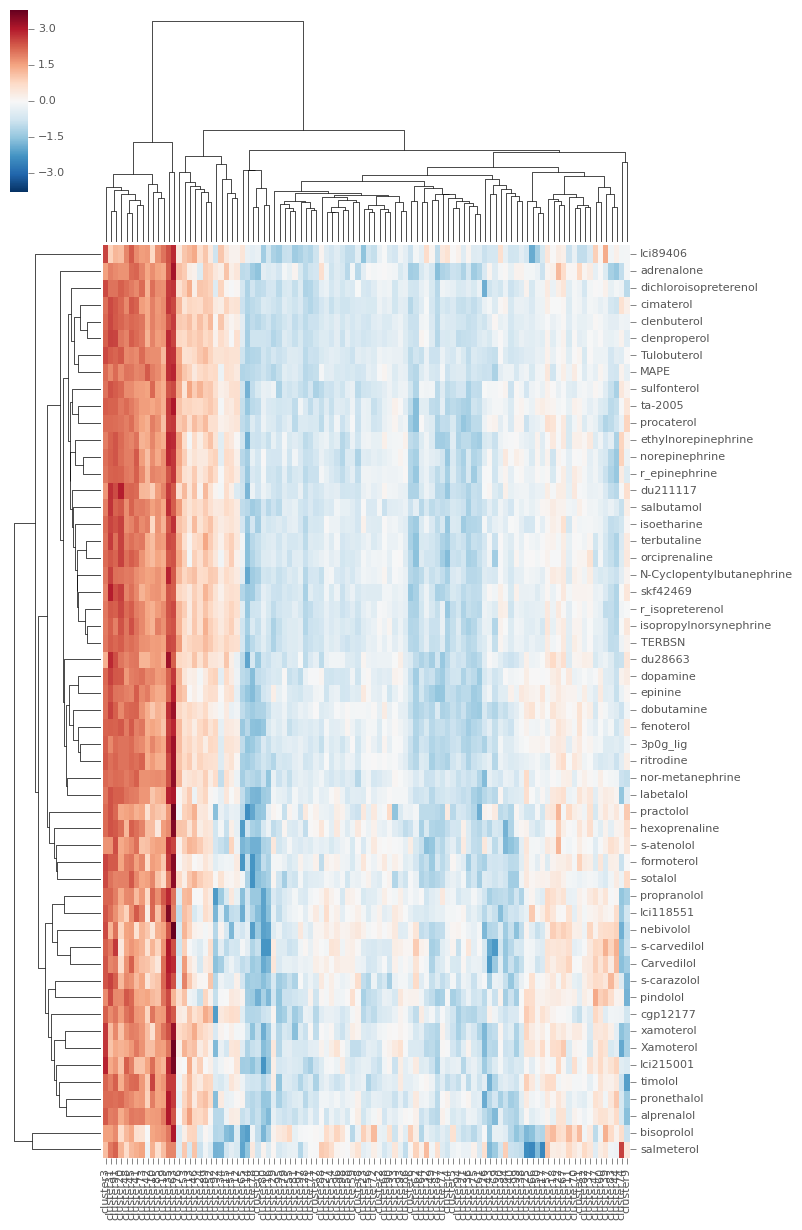

In [119]:
from scipy.stats import pearsonr
import plots
reload(plots)
from plots import *
"""
samples_tica = pd.read_csv(tica_coords_csv, index_col=0)
samples_docking = pd.read_csv(docking_multiple_ligands, index_col=0)
common_indices = list(set(samples_docking.index.values).intersection(samples_tica.index.values))
samples_tica = samples_tica.loc[common_indices]
samples_docking = samples_docking.loc[common_indices]


pearson_matrix = np.zeros((samples_docking.shape[1], samples_tica.shape[1]))
for i in range(0, pearson_matrix.shape[0]):
    for j in range(0, pearson_matrix.shape[1]):
        pearson_matrix[i][j] = pearsonr(samples_docking.values[:,i], samples_tica.values[:,j])[0]
MI_matrix = np.abs(compute_sr_matrix(samples_docking.values, samples_tica.values))
"""
plt.clf()
first_entries = ["nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "xamoterol", "3p0g_lig", "isoetharine", "ethylnorepinephrine", "salbutamol", "norepinephrine"]
secret_compounds = [c for c in delta_delta_g.columns.values if "Compound" in c]
drug_order = first_entries + list(set(delta_delta_g.columns.values).difference(set(first_entries)).difference(set(secret_compounds)))
delta_delta_g = delta_delta_g[drug_order]
delta_delta_g.sort("nebivolol", inplace=True)

#plot_heatmap(scale(delta_delta_g.values).T, delta_delta_g.columns.values, delta_delta_g.index.values, save_file="%s/msm_n-clusters%d_lag-time%d_n-heatmap.pdf" %(tica_dir, n_clusters, msm_lag_time))
#plot_heatmap(MI_matrix, samples_docking.columns.values, samples_tica.columns.values, save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components))
ddg_scaled = copy.deepcopy(delta_delta_g)
ddg_scaled[delta_delta_g.columns.values] = scale(delta_delta_g.values)
#ddg_scaled.index = [n.split("cluster")[1] for n in ddg_scaled.index.values]


plot_clustermap(ddg_scaled.transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='average')





In [29]:
import matplotlib
matplotlib.matplotlib_fname()

u'/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [120]:
samples_normalized_features_averages_df.iloc[80].subtract(samples_normalized_features_averages_df.iloc[16]).abs().sort(inplace=False, ascending=False)

[LEU145, ASN148]    4.117036
[THR146, ALA150]    3.904156
[LYS147, ALA150]    3.526087
[THR146, ARG151]    3.441525
[ILE169, TYR174]    3.407620
[TRP173, TYR199]    2.719745
[PRO168, ARG175]    2.536648
[LYS147, ARG151]    2.397731
[GLN170, ARG175]    2.388398
[MET171, TYR174]    2.360945
[GLN170, TYR174]    2.337772
[LYS147, VAL152]    2.288700
[LEU145, ILE153]    2.258173
[GLU62, LYS147]     2.251272
[TYR70, LYS147]     2.222082
[MET171, ARG175]    2.100574
[ILE169, THR195]    2.085545
[SER111, ILE169]    2.084522
[ILE58, LYS147]     2.056813
[LEU144, LYS147]    2.043879
[ILE112, ILE169]    2.042278
[VAL160, THR164]    2.036606
[ASN148, ILE153]    2.010761
[PHE108, ILE169]    1.960350
[HIS172, ALA176]    1.955101
[TRP173, ARG175]    1.906919
[GLN65, LYS147]     1.890707
[VAL157, THR164]    1.879571
[CYS106, ILE169]    1.857790
[SER111, GLN170]    1.848983
[ILE169, ARG175]    1.843256
[ILE112, GLN170]    1.838881
[SER111, PRO168]    1.835915
[GLN142, THR146]    1.826334
[LEU115, ILE16

In [120]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
all_ligands = [lig for lig in delta_delta_g.columns.values if "Carv" not in lig and "Xam" not in lig and "Compound_" not in lig]
X = np.vstack([delta_delta_g[all_ligands].values, ddg_scaled[all_ligands].values]).T
y = all_ligands
for i in range(0, len(y)):
    if "neb" in y[i] or "carv" in y[i]:
        y[i] = "biased_antagonist"
    else:
        y[i] = "not_biased_antagonist"
y = np.array(y).reshape((-1,1))
n_exp = 100
importances = []
for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt', n_jobs=-1)
    rfc.fit(X,y)
    importances.append(rfc.feature_importances_)
importances_mu = np.mean(np.array(importances), axis=0)
importances_df = pd.DataFrame(importances_mu, index=delta_delta_g.index.values.tolist() + ["%s_scaled" %n for n in ddg_scaled.index.values.tolist()], columns=["importance"]).sort("importance", inplace=False, ascending=False)
importances_df.iloc[0:20]
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

importance
cluster61_scaled    0.034441
cluster16_scaled    0.033659
cluster44           0.033520
cluster61           0.033420
cluster16           0.032927
cluster44_scaled    0.020437
cluster74_scaled    0.019953
cluster20_scaled    0.019025
cluster89           0.018825
cluster76           0.018442
cluster80           0.015213
cluster76_scaled    0.014772
cluster14           0.014765
cluster74           0.014757
cluster80_scaled    0.014629
cluster89_scaled    0.014400
cluster58_scaled    0.014322
cluster83           0.014235
cluster14_scaled    0.013833
cluster5_scaled     0.013506

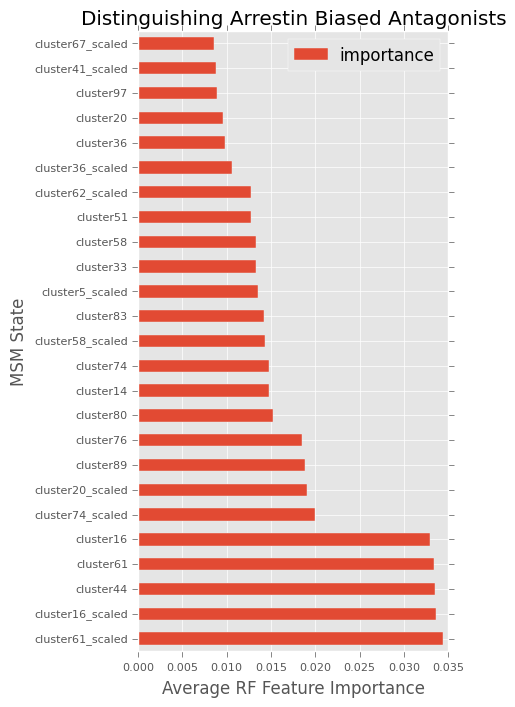

In [121]:
first_app = []
for n in importances_df.index.values:
    if n.split("_scaled")[0] not in first_app:
        first_app.append(n)
importances_df.loc[first_app].iloc[0:10]
plt.rcParams['xtick.labelsize'] = 8
importances_df.loc[first_app].iloc[0:25].plot(kind='barh', figsize=(4,8))
plt.xlabel("Average RF Feature Importance")
plt.ylabel("MSM State")
plt.title("Distinguishing Arrestin Biased Antagonists")

/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


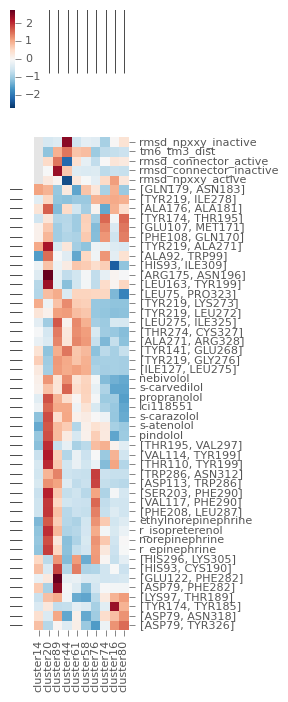

In [123]:
import plots
reload(plots)
from plots import *
names = [n.split("_scaled")[0] for n in importances_df.index.values.tolist()]
new_names = []
for n in names:
    if n not in new_names: new_names.append(n)
plot_clustermap(pd.concat([samples_top_features_avg_df, samples_pnas_avg_df, ddg_scaled[["norepinephrine", "r_epinephrine", "ethylnorepinephrine", "r_isopreterenol", "nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "pindolol", "propranolol", 'Ici118551']]],axis=1).loc[new_names[:10]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_arrestin_biased_antagonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=True, row_cluster=True, ytick_labelsize=8, xtick_labelsize=8)

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
rfc = RandomForestClassifier(n_estimators=5000, max_features='sqrt', n_jobs=-1)
X = delta_delta_g.values.T
y = copy.deepcopy(delta_delta_g.columns.values)
for i in range(0, len(y)):
    if "neb" in y[i] or "carv" in y[i]:
        y[i] = "biased_antagonist"
    else:
        y[i] = "not_biased_antagonist"
y = np.array(y).reshape((-1,1))
rfc.fit(X,y)
importances = pd.DataFrame(rfc.feature_importances_, index=delta_delta_g.index.values, columns=["importance"]).sort("importance", inplace=False, ascending=False)
importances.iloc[0:10]
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

In [197]:

n_experiments = 50
importances = []
accuracies = []
for n_trees in range(10, 500, 50):
    rfc = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', n_jobs=-1, oob_score=True)
    #rfc = LogisticRegression(penalty='l1', C=20.)
    #gprot_agonists = ["norepinephrine", "procaterol"]
    #shuffle(gprot_agonists)
    
    #arrestin_agonists = ["nebivolol", "s-carvedilol"]
    arrestin_agonists = ["ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine"]
    #gprot_agonists = ["s-atenolol", "s-carazolol", "timolol", "bisoprolol", "Ici118551", "propranolol", "pindolol", "alprenalol"]
    gprot_agonists = [a for a in delta_delta_g.columns.values if a not in arrestin_agonists and "arved" not in a and "Xam" not in a]
    shuffle(gprot_agonists)
    shuffle(arrestin_agonists)
    
    train_gprot_agonists = gprot_agonists[:30]
    test_gprot_agonists = gprot_agonists[30:]

    train_arrestin_agonists = arrestin_agonists[:2]
    test_arrestin_agonists = arrestin_agonists[2:]

    X = delta_delta_g[gprot_agonists + arrestin_agonists]
    y_train = ["gprot_agonist" for i in train_gprot_agonists] + ["arrestin_agonist" for i in train_arrestin_agonists]
    y_test = ["gprot_agonist" for i in test_gprot_agonists] + ["arrestin_agonist" for i in test_arrestin_agonists]
    y_train = np.array(y_train).reshape((-1,1))
    #lb = preprocessing.LabelBinarizer()
    y_test = np.array(y_test).reshape((-1,1))
    #y_train = lb.fit_transform(y_train)
    #y_test = lb.fit_transform(y_test)


    X_train = X[train_gprot_agonists + train_arrestin_agonists].values
    X_test = X[test_gprot_agonists + test_arrestin_agonists].values
    X_train = np.vstack([X_train,scale(X_train)]).T
    X_test = np.vstack([X_test,scale(X_test)]).T
    rfc.fit(X_train,y_train)
    importances.append(rfc.feature_importances_)
    y_pred = rfc.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))
    

    #X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

In [ ]:
from sklearn.metrics import roc_curve, aucplt.plot(range(10,500,50), accuracies)
plt.show()

In [193]:
importances_df = pd.DataFrame(importances, columns=delta_delta_g.index.values.tolist()+["%s_scaled" %n for n in delta_delta_g.index.values.tolist()]).mean(axis=0).transpose().sort(inplace=False, ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


In [178]:
rfc.predict(X_test)

array(['gprot_agonist', 'arrestin_agonist', 'arrestin_agonist'], 
      dtype='|S16')

In [52]:
deltas_tica_scaled = copy.deepcopy(deltas_tica)
deltas_tica_scaled[delta_delta_g.columns] = scale(deltas_tica[delta_delta_g.columns].values)
new_index = []
for n in deltas_tica.index.values:
    if n in delta_delta_g.index.values:
        new_index.append("%s_scaled" %n)
    else:
        new_index.append(n)
deltas_tica_scaled.index = new_index

In [ ]:
from sklearn.preprocessing import scale
delta_delta_g[delta_delta_g.columns.values] = scale(delta_delta_g.values)
#delta_delta_g = delta_delta_g.iloc[[80, 16, 43, 0, 1, 2, 4, 5, 6]]
delta_delta_g = delta_delta_g.transpose()
delta_delta_g["label"] = 0
delta_delta_g["label"].loc[train_agonists] = "agonist"
delta_delta_g["label"].loc[train_biased_antagonists] = "biased_antagonist"
delta_delta_g["label"].loc[train_inverse_agonists] = "inverse_agonists"
delta_delta_g["label"].loc[train_gprot_agonists] = "gprot_agonists"
delta_delta_g["label"].loc[train_arrestin_agonists] = "arrestin_agonists"
delta_delta_g["label"].loc[train_partial_agonists] = "partial_agonists"
X = delta_delta_g.loc[delta_delta_g["label"] != 0][[t for t in delta_delta_g.columns.values if t != "label"]]
y = delta_delta_g.loc[delta_delta_g["label"] != 0]["label"]

In [1125]:
from sklearn.externals.six import StringIO
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data,  
                         feature_names=X.columns.values) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())  

NameError: global name 'dot_parser' is not defined

In [1117]:
visualize_tree(dt, X.columns.values)

In [45]:
train_biased_antagonists = ["s-carvedilol", "nebivolol"]
test_biased_antagonists = [lig for lig in df_agg.columns.values if lig not in train_biased_antagonists]

test_agonists = [lig for lig in df_agg.columns.values if lig not in train_agonists]

train_inverse_agonists = ["s-carazolol", "Ici118551", "propranolol"]

train_gprot_agonists = ["salbutamol", "MAPE"]
train_arrestin_agonists = ["N-Cyclopentylbutanephrine", "isoetharine"]

train_agonists = ["r_isopreterenol", "adrenalone", "MAPE"]

biased_antagonist_titles = []
biased_antagonist_indices = []

biased_antagonist_index_sets = []
for biased_antagonist in train_biased_antagonists:
    biased_antagonist_index_sets.append(set())
    delta_delta_g["%s_argsort" %biased_antagonist] = np.argsort(delta_delta_g[biased_antagonist].values)
    biased_antagonist_titles.append("%s_argsort" %biased_antagonist)
    for inverse_agonist in train_inverse_agonists:
        delta_delta_g["%s_subtract_%s" %(biased_antagonist, inverse_agonist)] = delta_delta_g[biased_antagonist].subtract(delta_delta_g[inverse_agonist])
        delta_delta_g["%s_subtract_%s_argsort" %(biased_antagonist, inverse_agonist)] = np.argsort(delta_delta_g["%s_subtract_%s" %(biased_antagonist, inverse_agonist)].values)
        biased_antagonist_titles.append("%s_subtract_%s_argsort" %(biased_antagonist, inverse_agonist))
        biased_antagonist_index_sets.append(set())

inverse_agonist_index_sets = []
inverse_agonist_indices = []
inverse_agonist_titles = []
for inverse_agonist in train_inverse_agonists:
    inverse_agonist_index_sets.append(set())
    delta_delta_g["%s_argsort" %inverse_agonist] = np.argsort(delta_delta_g[inverse_agonist].values)
    inverse_agonist_titles.append("%s_argsort" %inverse_agonist)
    for agonist in (train_agonists + train_biased_antagonists):
        delta_delta_g["%s_subtract_%s" %(inverse_agonist, agonist)] = delta_delta_g[inverse_agonist].subtract(delta_delta_g[agonist])
        delta_delta_g["%s_subtract_%s_argsort" %(inverse_agonist, agonist)] = np.argsort(delta_delta_g["%s_subtract_%s" %(inverse_agonist, agonist)].values)
        inverse_agonist_titles.append("%s_subtract_%s_argsort" %(inverse_agonist, agonist))
        inverse_agonist_index_sets.append(set())        



agonist_titles = []
agonist_indices = []
agonist_index_sets = []
for agonist in train_agonists:
    agonist_index_sets.append(set())
    delta_delta_g["%s_argsort" %agonist] = np.argsort(delta_delta_g[agonist].values)
    agonist_titles.append("%s_argsort" %agonist)
    for inverse_agonist in train_inverse_agonists:
        delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)] = delta_delta_g[agonist].subtract(delta_delta_g[inverse_agonist])
        delta_delta_g["%s_subtract_%s_argsort" %(agonist, inverse_agonist)] = np.argsort(delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)].values)
        agonist_titles.append("%s_subtract_%s_argsort" %(agonist, inverse_agonist))
        agonist_index_sets.append(set())

arrestin_agonist_titles = []
arrestin_agonist_indices = []
arrestin_agonist_index_sets = []
for agonist in train_arrestin_agonists:
    arrestin_agonist_index_sets.append(set())
    delta_delta_g["%s_argsort" %agonist] = np.argsort(delta_delta_g[agonist].values)
    arrestin_agonist_titles.append("%s_argsort" %agonist)
    for inverse_agonist in train_gprot_agonists:
        delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)] = delta_delta_g[agonist].subtract(delta_delta_g[inverse_agonist])
        delta_delta_g["%s_subtract_%s_argsort" %(agonist, inverse_agonist)] = np.argsort(delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)].values)
        arrestin_agonist_titles.append("%s_subtract_%s_argsort" %(agonist, inverse_agonist))
        arrestin_agonist_index_sets.append(set())


gprot_agonist_titles = []
gprot_agonist_indices = []
gprot_agonist_index_sets = []
for agonist in train_gprot_agonists:
    gprot_agonist_index_sets.append(set())
    delta_delta_g["%s_argsort" %agonist] = np.argsort(delta_delta_g[agonist].values)
    gprot_agonist_titles.append("%s_argsort" %agonist)
    for inverse_agonist in train_arrestin_agonists:
        delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)] = delta_delta_g[agonist].subtract(delta_delta_g[inverse_agonist])
        delta_delta_g["%s_subtract_%s_argsort" %(agonist, inverse_agonist)] = np.argsort(delta_delta_g["%s_subtract_%s" %(agonist, inverse_agonist)].values)
        gprot_agonist_titles.append("%s_subtract_%s_argsort" %(agonist, inverse_agonist))
        gprot_agonist_index_sets.append(set())
        
biased_antagonist_iteration_scores = []


biased_antagonist_indices = set()
all_biased_antagonist_indices = []
agonist_indices = set()
all_agonist_indices = []
agonist_iteration_scores = []
arrestin_agonist_indices = set()
all_arrestin_agonist_indices = []
gprot_agonist_indices = set()
all_gprot_agonist_indices = []

inverse_agonist_indices = set()
all_inverse_agonist_indices = []

from scipy import stats

k=5
iteration = 0
while (iteration < 50) and (len(biased_antagonist_indices) < k):
    new_indices = delta_delta_g[biased_antagonist_titles].values[iteration,:]
    [biased_antagonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    biased_antagonist_indices = set.intersection(*biased_antagonist_index_sets)
    all_biased_antagonist_indices.append(biased_antagonist_indices)
    iteration += 1

iteration = 0
while (iteration < 50) and (len(inverse_agonist_indices) < 5):
    new_indices = delta_delta_g[inverse_agonist_titles].values[iteration,:]
    [inverse_agonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    inverse_agonist_indices = set.intersection(*inverse_agonist_index_sets)
    all_inverse_agonist_indices.append(inverse_agonist_indices)
    iteration += 1    

iteration = 0
while (iteration < 50) and (len(agonist_indices) < k):
    new_indices = delta_delta_g[agonist_titles].values[iteration,:]
    [agonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    agonist_indices = set.intersection(*agonist_index_sets)
    all_agonist_indices.append(agonist_indices)
    iteration += 1

iteration = 0
while (iteration < 50) and (len(gprot_agonist_indices) < k):
    new_indices = delta_delta_g[gprot_agonist_titles].values[iteration,:]
    [gprot_agonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    gprot_agonist_indices = set.intersection(*gprot_agonist_index_sets)
    #gprot_agonist_indices = gprot_agonist_indices.difference(agonist_indices).difference(biased_antagonist_indices)
    all_gprot_agonist_indices.append(gprot_agonist_indices)
    iteration += 1

iteration = 0
while (iteration < 50) and (len(arrestin_agonist_indices) < k):
    new_indices = delta_delta_g[arrestin_agonist_titles].values[iteration,:]
    [arrestin_agonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    arrestin_agonist_indices = set.intersection(*arrestin_agonist_index_sets)
    #arrestin_agonist_indices = arrestin_agonist_indices.difference(agonist_indices).difference(biased_antagonist_indices)
    all_arrestin_agonist_indices.append(arrestin_agonist_indices)
    iteration += 1

"""
for iteration in range(0,50):
    new_indices = delta_delta_g[biased_antagonist_titles].values[iteration,:]
    [biased_antagonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    biased_antagonist_indices = set.intersection(*biased_antagonist_index_sets)
    all_biased_antagonist_indices.append(biased_antagonist_indices)
    if len(biased_antagonist_indices) >= 5:
        biased_antagonist_iteration_scores.append(0.)
        continue
    
    new_indices = delta_delta_g[agonist_titles].values[iteration,:]
    [agonist_index_sets[i].add(new_indices[i]) for i in range(0,len(new_indices))]
    agonist_indices = set.intersection(*agonist_index_sets)
    all_agonist_indices.append(agonist_indices)
    if len(agonist_indices) < 1:
        agonist_iteration_scores.append(0.)
        continue

    arrestin_agonist_indices = arrestin_agonist_indices.union(set(delta_delta_g[arrestin_agonist_titles].values[iteration,:]))
    gprot_agonist_indices = gprot_agonist_indices.union(set(delta_delta_g[gprot_agonist_titles].values[iteration,:]))
    all_gprot_agonist_indices.append(gprot_agonist_indices)
    
    biased_antagonist_change = stats.hmean(new_populations.iloc[list(biased_antagonist_indices)][train_biased_antagonists].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(biased_antagonist_indices)].sum(axis=0).values[0]).values)
    biased_antagonist_iteration_scores.append(biased_antagonist_change)
    
    agonist_change = stats.hmean(new_populations.iloc[list(agonist_indices)][train_agonists].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(agonist_indices)].sum(axis=0).values[0]).values)
    agonist_iteration_scores.append(agonist_change)
    
    #agonist_change = stats.hmean(new_populations.iloc[list(agonist_indices)][train_agonists].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(agonist_indices)].sum(axis=0).values[0]).values)
    #agonist_iteration_scores.append(agonist_change)

print(biased_antagonist_iteration_scores)
np.argmax(biased_antagonist_iteration_scores)
biased_antagonist_indices = all_biased_antagonist_indices[np.argmax(biased_antagonist_iteration_scores)]
biased_antagonist_indices = [80]
    
agonist_indices = all_agonist_indices[np.argmax(agonist_iteration_scores)]
agonist_indices = [62]
"""
biased_antagonist_change = new_populations.iloc[list(biased_antagonist_indices)].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(biased_antagonist_indices)].sum(axis=0).values[0]).sort(ascending=True, inplace=False)        
arrestin_indices = biased_antagonist_indices.union(arrestin_agonist_indices)
arrestin_change = new_populations.iloc[list(arrestin_indices)].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(arrestin_indices)].sum(axis=0).values[0]).sort(ascending=True, inplace=False)        
gprot_agonist_change = new_populations.iloc[list(gprot_agonist_indices)].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(gprot_agonist_indices)].sum(axis=0).values[0]).sort(ascending=True, inplace=False)
agonist_change = new_populations.iloc[list(agonist_indices)].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(agonist_indices)].sum(axis=0).values[0]).sort(ascending=True, inplace=False)
inverse_agonist_change = new_populations.iloc[list(inverse_agonist_indices)].sum(axis=0).divide(msm_cluster_eq_pops_df.iloc[list(inverse_agonist_indices)].sum(axis=0).values[0]).sort(ascending=True, inplace=False)
#agonist_change = agonist_change.divide(inverse_agonist_change)

#agonist_change.loc[agonist_change.index] = scale(agonist_change.values)
#biased_antagonist_change.loc[biased_antagonist_change.index] = scale(biased_antagonist_change.values)
#gprot_agonist_change.loc[gprot_agonist_change.index] = scale(gprot_agonist_change.values)
#arrestin_change.loc[arrestin_change.index] = scale(arrestin_change)

#common = gprot_agonist_indices.intersection(arrestin_agonist_indices)
#gprot_agonist_indices = gprot_agonist_indices.difference(common)
#arrestin_agonist_indices = arrestin_agonist_indices.difference(common)
        

NameError: name 'df_agg' is not defined

In [491]:
print(biased_antagonist_indices)
print(arrestin_agonist_indices)
print(arrestin_indices)
print(gprot_agonist_indices)
print(agonist_indices)
print(inverse_agonist_indices)

set([80, 16, 84, 49, 87])
set([4, 44, 6, 62, 79])
set([16, 4, 6, 44, 79, 80, 49, 84, 87, 62])
set([33, 27, 29, 54, 65])
set([8, 58, 83, 44, 6])
set([])


In [477]:
pandas.set_option('display.max_columns', None)

In [478]:
tica_deltas = pd.concat([pnas_cluster_averages_df, tica_cluster_averages_df, delta_delta_g], axis=1)
tica_deltas.iloc[list(biased_antagonist_indices)].sort("s-carvedilol")

tm6_tm3_dist  rmsd_npxxy_inactive  rmsd_npxxy_active  \
cluster16      8.098881             0.504904           0.989428   
cluster80      8.162954             0.538104           0.956173   
cluster84      8.187723             0.600510           0.932284   
cluster49      8.136475             0.572205           0.931885   
cluster87     13.201396             0.579967           0.788119   

           rmsd_connector_inactive  rmsd_connector_active       tIC.1  \
cluster16                 0.403042               1.487263  298.327555   
cluster80                 0.360018               1.498056  847.962433   
cluster84                 0.439035               1.445410  756.482639   
cluster49                 0.353415               1.513465  714.294737   
cluster87                 0.854676               1.255467 -379.289933   

                tIC.2       tIC.3       tIC.4      tIC.5       tIC.6  \
cluster16 -155.705678  -41.344052  117.561613  35.679950  -48.618774   
cluster80  -84.929557   12.544195 -197.654840  20.731520  -18.199054   
cluster84   60.057638   35.817032  131.208931  70.236430   49.651602   
cluster49  -27.212609  -98.696675  100.758226   2.123256   69.620644   
cluster87  522.431203 -134.208048   64.509006 -23.147631  119.801653   

                tIC.7      tIC.8       tIC.9     tIC.10     tIC.11     tIC.12  \
cluster16   16.720238  15.478937  232.499244   4.969431 -36.170179 -32.143499   
cluster80   -6.332496  51.194326   -0.387965  13.010766  10.696018 -28.627085   
cluster84 -116.424047  -5.796052  -54.781801   1.305781  -6.846994 -18.134164   
cluster49  -60.969789   2.982377    5.124950  24.354661   9.422267   2.117906   
cluster87   73.276824 -25.249657    7.576592   1.418153  -2.060734 -34.489282   

               tIC.13     tIC.14     tIC.15     tIC.16     tIC.17    tIC.18  \
cluster16  -62.869451  25.541496   3.861923  26.951820 -19.436133  6.110124   
cluster80 -113.517474 -28.686492 -29.067618  60.014009  -4.274494  2.474472   
cluster84  -36.298387 -14.266051  48.028382  12.478828  30.590482 -4.263914   
cluster49   64.234936 -16.857238 -12.220258   4.935124   2.858376 -5.669439   
cluster87  -15.225767  21.938563  -7.560167  -6.292116  -2.357628 -5.014368   

              tIC.19     tIC.20     tIC.21     tIC.22     tIC.23     tIC.24  \
cluster16  -1.698835 -21.626648  -5.085284 -21.061992 -19.170225 -29.306627   
cluster80   6.123300  -5.509086  13.882322 -23.992149   2.783879  -3.879533   
cluster84 -11.471879  15.128952  16.038524 -10.741200   5.465042   1.336809   
cluster49   0.098164  -0.690512   4.835618   0.045469   0.474479   0.634310   
cluster87  15.122831   0.995383   1.574793   6.829676  10.703817  -6.920377   

              tIC.25   timolol  isopropylnorsynephrine  Compound_B  \
cluster16 -13.701847 -0.707910               -0.748140   -0.871040   
cluster80 -13.639430 -0.865977               -0.526073   -0.893023   
cluster84   3.292116 -0.525977               -0.354873   -0.859423   
cluster49  -2.636016 -0.427977               -0.811673   -0.665823   
cluster87   1.262015 -0.743177               -0.822473   -0.397023   

           Compound_H  labetalol  cimaterol  ethylnorepinephrine  s-carazolol  \
cluster16   -1.107014  -1.075577  -0.738194            -0.732917    -0.819216   
cluster80   -1.093364  -1.121594  -0.683011            -0.628084    -0.932083   
cluster84   -0.424164  -0.792794  -0.226211            -0.392484    -0.638483   
cluster49   -0.895364  -0.937994  -0.758211            -0.604884    -0.634083   
cluster87   -0.815764  -0.804394  -0.968611            -0.932884    -0.491283   

           fenoterol  pindolol  formoterol   du28663  Compound_E  Ici215001  \
cluster16  -0.783067 -0.894128   -1.017132 -0.773567   -1.071275  -0.872663   
cluster80  -1.333984 -0.711461   -0.865182 -0.729001   -1.021842  -1.130429   
cluster84  -0.793984 -0.738661   -0.797982 -0.689401   -0.706642  -0.523629   
cluster49  -1.063184 -0.615061   -1.103182 -0.980601   -0.558242  -0.614429

In [131]:
reference_docking_dir = "/home/enf/b2ar_analysis/reference_docking/docking_SP"
reference_ligand_docking = "%s/all_docking_scores.csv" % reference_docking_dir

analyze_docking_results_multiple(reference_docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands + inverse_ligands, summary = reference_ligand_docking , redo = True)



Analyzing docking results
/home/enf/b2ar_analysis/reference_docking/docking_SP
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dobutamine', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol', 'hexoprenaline', 'isopropylnorsynephrine', 'labetalol', 'meto

In [297]:
reference_docking = pd.read_csv(reference_ligand_docking, index_col=0).dropna()
reference_docking.columns = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in reference_docking.columns.values]
reference_docking.loc["null_scores"] = reference_docking.iloc[1].subtract(reference_docking.iloc[0])                             

In [298]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize, scale, StandardScaler

features = delta_delta_g.transpose()
null_features = reference_docking.transpose().loc[features.index]

classes = pd.read_csv("/home/enf/b2ar_analysis/b2ar_antagonists_agonists3.csv", header=None)

agonists = classes.iloc[1].dropna().values.tolist()
agonists = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in agonists]

antagonists = classes.iloc[0].dropna().values.tolist()
antagonists = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in antagonists]


labels = np.zeros((features.shape[0], 1), dtype=object)
for agonist in agonists:
    try:
        labels[features.index.values.tolist().index(agonist), 0] = "agonist"
    except:
        print(agonist)
        continue
for agonist in antagonists:
    try:
        labels[features.index.values.tolist().index(agonist), 0] = "antagonist"
    except:
        print(agonist)
        continue
non_zero_inds = np.where(labels != 0)[0]
X = features.values[non_zero_inds,:]
N = null_features.values[non_zero_inds,2]
C = N
y = labels[non_zero_inds, :]
y = label_binarize(y, ["agonist", "antagonist"])





skf42090


In [ ]:
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

test_accuracies = []
test_r2s = []
C_test_accuracies = []
C_test_r2s = []

for j in range(0,10):
    n_exp = 1
    accuracies = []
    r2s = []
    importances = []

    gbr_accuracies = []
    gbr_r2s = []
    gbr_importances = []

    oob_scores = []

    C_accuracies = []
    C_r2s = []
    C_importances = []
    C_oob_scores = []

    C_gbr_accuracies = []
    C_gbr_r2s = []
    C_gbr_importances = []

    X = delta_delta_g[common_ligands].values.T
    C = null_features.loc[common_ligands].values
    y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))

    X, X_pristine, y, y_pristine, C, C_pristine = train_test_split(X, y, C, train_size=0.7)

    X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
    

    
    for i in range(0, n_exp):
        X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
        sc = StandardScaler()
        sc.fit(X_train)
        X_train = np.hstack([X_train, sc.transform(X_train)])
        X_test = np.hstack([X_test, sc.transform(X_test)])

        sc = StandardScaler()
        sc.fit(C_train)
        C_train = np.hstack([C_train, sc.transform(C_train)])
        C_test = np.hstack([C_test, sc.transform(C_test)])

        rfc = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
        rfc.fit(X_train,y_train)
        accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
        r2s.append(r2_score(y_test, rfr.predict(X_test)))
        importances.append(rfr.feature_importances_)
        oob_scores.append(rfr.oob_score_)
    mean_importances = np.mean(np.vstack(importances), axis=0)
    top_features = np.argsort(-1.0*mean_importances)[0:5]
    print(top_features)

    sc = StandardScaler()
    sc.fit(X)
    X_train = np.hstack([X, sc.transform(X)])
    X_test = np.hstack([X_pristine, sc.transform(X_pristine)])

    sc = StandardScaler()
    sc.fit(C)
    C_train = np.hstack([C, sc.transform(C)])
    C_test = np.hstack([C_pristine, sc.transform(C_pristine)])

    y_train = y
    y_test = y_pristine

    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train)
    test_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
    test_r2s.append(r2_score(y_test, rfr.predict(X_test)))

    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(C_train, y_train)
    C_test_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(C_test).reshape((-1,1))))))
    C_test_r2s.append(r2_score(y_test, rfr.predict(C_test)))

    
    

    

In [76]:
len(non_zero_inds)

51

In [52]:
n_exp = 100
train_aucs = [] 
logaucs = []

for i in range(0, n_exp):
    print(i)
    rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    sc = StandardScaler()
    X_train = sc.fit_transform(X)
    y_train = copy.deepcopy(y)
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_train)
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_train, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    train_aucs.append(roc_auc)
    logaucs.append(logauc2(fpr,tpr))

0
1

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



2
3

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



4
5

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



6
7

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



8
9

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



10
11

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



12
13

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



14
15

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



16
17

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



18
19

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



20
21

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



22
23

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



24
25

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



26
27

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



28
29

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



30
31

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



32
33

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



34
35

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



36
37

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



38
39

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



40
41

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



42
43

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



44
45

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



46
47

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



48
49

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



50
51

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



52
53

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



54
55

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



56
57

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



58
59

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



60
61

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



62
63

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



64
65

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



66
67

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



68
69

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



70
71

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



72
73

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



74
75

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



76
77

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



78
79

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



80
81

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



82
83

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



84
85

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



86
87

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



88
89

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



90
91

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



92
93

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



94
95

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



96
97

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



98
99

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
n_exp = 100
train_aucs = [] 
logaucs = []

for i in range(0, n_exp):
    print(i)
    rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    sc = StandardScaler()
    X_train = sc.fit_transform(X)
    y_train = copy.deepcopy(y)
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_train)
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_train, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    train_aucs.append(roc_auc)
    logaucs.append(logauc2(fpr,tpr))

In [55]:
fpr

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.05,  0.1 ,  0.15,
        0.2 ,  0.25,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  1.  ])

In [56]:
tpr

array([ 0.06666667,  0.13333333,  0.2       ,  0.26666667,  0.33333333,
        0.4       ,  0.46666667,  0.53333333,  0.6       ,  0.66666667,
        0.73333333,  0.8       ,  0.86666667,  0.93333333,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

(0.0, 1.05)

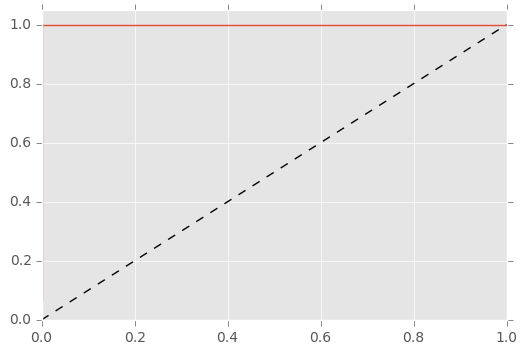

In [59]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [54]:
np.mean(logaucs)

0.43367666522132708

In [ ]:
n_exp = 100
aucs = [] 


for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    train_inds = np.random.choice(range(0, np.shape(X)[0]))
    test_inds = list(set(range(0, np.shape(X)[0])).difference(set(train_inds.tolist())))
    X_train = X[train_inds,:]
    y_train = y[train_inds,:]
    X_test = X[test_inds,:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = np.hstack([X_train, sc.transform(X_train)])
    X_test = np.hstack([X_test, sc.transform(X_test)])
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_test)
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

In [107]:
n_trees_vals = list(range(10,100,10)) + list(range(10,1500,100))
oob_scores = []
for n_trees in n_trees_vals:
    rfc = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', n_jobs=-1, oob_score=True)
    sc = StandardScaler()
    sc.fit(X)
    X_train = np.hstack([X, sc.transform(X)])
    rfc.fit(X_train,y)
    oob_scores.append(rfc.oob_score_)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

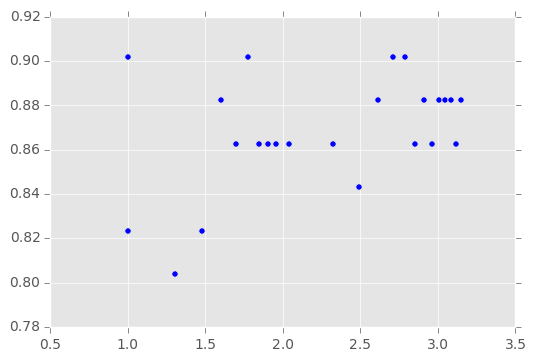

In [110]:
plt.scatter(np.log10(n_trees_vals), oob_scores)

In [101]:
oob_scores

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [118]:
deltas_tica.loc[pd.DataFrame(rfc.feature_importances_, index = delta_delta_g.index.values.tolist() + delta_delta_g.index.values.tolist(), columns=["importance"]).sort("importance", inplace=False, ascending=False).index].iloc[0:10]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


timolol  isopropylnorsynephrine  Compound_B  Compound_H  \
cluster44 -0.144891               -0.950239   -0.202879   -0.284988   
cluster76 -0.413935                0.386596   -0.230184    0.046160   
cluster44 -0.144891               -0.950239   -0.202879   -0.284988   
cluster76 -0.413935                0.386596   -0.230184    0.046160   
cluster6  -0.517691               -0.961439   -0.369679   -0.543788   
cluster92 -0.568491                0.065761   -0.819679   -0.443388   
cluster6  -0.517691               -0.961439   -0.369679   -0.543788   
cluster92 -0.568491                0.065761   -0.819679   -0.443388   
cluster62 -0.438891               -0.959439   -0.451679   -0.607788   
cluster75 -0.488091               -0.954239   -0.394079   -0.592188   

           labetalol  cimaterol  ethylnorepinephrine  s-carazolol  olodaterol  \
cluster44  -0.311646  -0.823459            -0.878427    -0.047712   -1.064606   
cluster76  -0.287559   0.438019             0.271712    -0.429312    0.952072   
cluster44  -0.311646  -0.823459            -0.878427    -0.047712   -1.064606   
cluster76  -0.287559   0.438019             0.271712    -0.429312    0.952072   
cluster6   -0.626446  -1.004259            -0.773627    -0.458912   -1.285006   
cluster92  -0.408046  -0.090659            -0.136027    -0.724112    0.409794   
cluster6   -0.626446  -1.004259            -0.773627    -0.458912   -1.285006   
cluster92  -0.408046  -0.090659            -0.136027    -0.724112    0.409794   
cluster62  -0.820846  -0.827459            -0.826027     0.013888   -2.115406   
cluster75  -1.033646  -0.908659            -0.882827    -0.622912   -1.269006   

             ah3474  fenoterol  pindolol  formoterol   du28663  Compound_E  \
cluster44 -0.943990  -0.877989 -0.207900   -0.226948 -0.790360   -0.388706   
cluster76  0.388149   0.389976 -0.041343   -0.263261  0.023484   -0.120428   
cluster44 -0.943990  -0.877989 -0.207900   -0.226948 -0.790360   -0.388706   
cluster76  0.388149   0.389976 -0.041343   -0.263261  0.023484   -0.120428   
cluster6  -0.795990  -0.757189 -0.202300   -0.526148 -0.624360   -0.329106   
cluster92  0.090410   0.150411 -0.593900   -0.588148 -0.134360   -0.784306   
cluster6  -0.795990  -0.757189 -0.202300   -0.526148 -0.624360   -0.329106   
cluster92  0.090410   0.150411 -0.593900   -0.588148 -0.134360   -0.784306   
cluster62 -1.145590  -1.119189 -0.202300   -0.728948 -0.819560   -0.566306   
cluster75 -1.007990  -1.102789 -0.542700   -0.767748 -0.924360   -0.697506   

           Ici215001  acebutolol  s-atenolol   sotalol  pronethalol  \
cluster44  -0.007222    0.490958   -0.115659 -0.205301     0.165606   
cluster76  -0.259257   -0.825755   -0.221589 -0.036292    -0.385038   
cluster44  -0.007222    0.490958   -0.115659 -0.205301     0.165606   
cluster76  -0.259257   -0.825755   -0.221589 -0.036292    -0.385038   
cluster6   -0.372422   -0.178642   -0.176059 -0.350901    -0.454794   
cluster92  -0.484822   -0.679842   -0.556859 -0.324501    -1.020394   
cluster6   -0.372422   -0.178642   -0.176059 -0.350901    -0.454794   
cluster92  -0.484822   -0.679842   -0.556859 -0.324501    -1.020394   
cluster62  -0.196822   -0.155442   -0.516059 -0.455301    -0.137994   
cluster75  -0.423222   -0.590642   -0.641259 -0.651701    -0.502394   

           Tulobuterol  practolol  ritrodine  Ici118551  Carvedilol  \
cluster44    -0.566770  -0.110665  -0.941521  -0.017075    0.303627   
cluster76     0.489891  -0.316752   0.363992  -0.619266   -0.484617   
cluster44    -0.566770  -0.110665  -0.941521  -0.017075    0.303627   
cluster76     0.489891  -0.316752   0.363992  -0.619266   -0.484617   
cluster6     -0.895570  -0.354265  -0.997521  -0.401075   -0.365573   
cluster92    -0.035170  -0.819465   0.042479  -0.932275   -1.034373   
cluster6     -0.895570  -0.354265  -0.997521  -0.401075   -0.365573   
cluster92    -0.035170  -0.819465   0.042479  -0.932275   -1.034373   
cluster62    -0.757170  -0.297065  -1.139121  -0.482675   

In [90]:
n_exp = 100
aucs = [] 
null_aucs = []
log_aucs = []
null_log_aucs = []

for i in range(0, n_exp):
    try:
        rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
        X_train, X_test, y_train, y_test, N_train, N_test = train_test_split(X, y, N, train_size=0.9)
        sc = StandardScaler()
        sc.fit(X_train)
        X_train = np.hstack([X_train, sc.transform(X_train)])
        X_test = np.hstack([X_test, sc.transform(X_test)])
        rfc.fit(X_train,y_train)
        y_score = rfc.predict_proba(X_test)
        null_score = N_test

        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
        null_fpr, null_tpr, _ = roc_curve(y_test, 1.-null_score)

        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        null_aucs.append(auc(null_fpr, null_tpr))

        thresh = int(np.where(fpr >= 0.001)[0][0])
        log_fpr = np.log10(fpr[thresh:])
        log_auc = auc(log_fpr, tpr[thresh:])
        log_aucs.append(log_auc)

        thresh = int(np.where(null_fpr >= 0.001)[0][0])
        log_fpr = np.log10(null_fpr[thresh:])
        log_auc = auc(log_fpr, null_tpr[thresh:])
        null_log_aucs.append(log_auc)
    except:
        continue
    
    

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [91]:
np.mean(np.nan_to_num(log_aucs))

0.72030018788699168

(array([  1.,   1.,   4.,   4.,  20.,  19.,  30.,   8.,  11.,   2.]),
 array([ 0.30103 ,  0.370927,  0.440824,  0.510721,  0.580618,  0.650515,
         0.720412,  0.790309,  0.860206,  0.930103,  1.      ]),
 <a list of 10 Patch objects>)

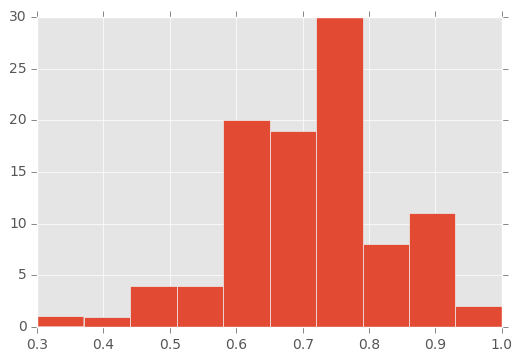

In [92]:
plt.hist(np.nan_to_num(log_aucs))

In [93]:
np.mean(np.nan_to_num(aucs))

0.93094047619047626

In [94]:
np.mean(np.nan_to_num(null_aucs))

0.9528253968253968

In [96]:
np.mean(np.nan_to_num(null_log_aucs))

0.73105431430145873

(array([  1.,   0.,   3.,   2.,   0.,   0.,   9.,   0.,   0.,  25.]),
 array([ 0.75 ,  0.775,  0.8  ,  0.825,  0.85 ,  0.875,  0.9  ,  0.925,
         0.95 ,  0.975,  1.   ]),
 <a list of 10 Patch objects>)

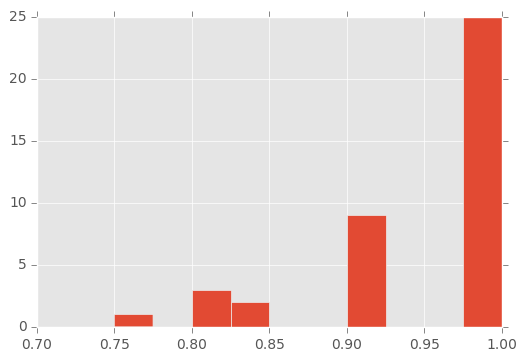

In [37]:
plt.hist(np.nan_to_num(aucs))

In [29]:
n_exp = 100
aucs = [] 


for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = np.hstack([X_train, sc.transform(X_train)])
    X_test = np.hstack([X_test, sc.transform(X_test)])
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_test)
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [ ]:
print(np.shape(X_train))

In [ ]:
print("hi")

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   3.,
          0.,   0.,   0.,   0.,   3.,   0.,   3.,   2.,   0.,   0.,   3.,
          0.,   6.,   9.,   0.,   0.,   0.,   2.,   0.,   0.,   9.,   0.,
          0.,   0.,   0.,   0.,   0.,  56.]),
 array([ 0.65 ,  0.657,  0.664,  0.671,  0.678,  0.685,  0.692,  0.699,
         0.706,  0.713,  0.72 ,  0.727,  0.734,  0.741,  0.748,  0.755,
         0.762,  0.769,  0.776,  0.783,  0.79 ,  0.797,  0.804,  0.811,
         0.818,  0.825,  0.832,  0.839,  0.846,  0.853,  0.86 ,  0.867,
         0.874,  0.881,  0.888,  0.895,  0.902,  0.909,  0.916,  0.923,
         0.93 ,  0.937,  0.944,  0.951,  0.958,  0.965,  0.972,  0.979,
         0.986,  0.993,  1.   ]),
 <a list of 50 Patch objects>)

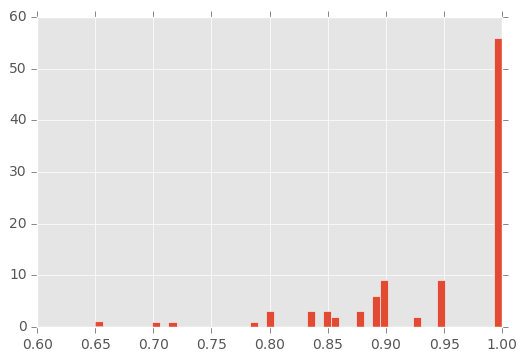

In [83]:
plt.hist(aucs, bins=50)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   0.,   0.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  61.]),
 array([ 0.7  ,  0.706,  0.712,  0.718,  0.724,  0.73 ,  0.736,  0.742,
         0.748,  0.754,  0.76 ,  0.766,  0.772,  0.778,  0.784,  0.79 ,
         0.796,  0.802,  0.808,  0.814,  0.82 ,  0.826,  0.832,  0.838,
         0.844,  0.85 ,  0.856,  0.862,  0.868,  0.874,  0.88 ,  0.886,
         0.892,  0.898,  0.904,  0.91 ,  0.916,  0.922,  0.928,  0.934,
         0.94 ,  0.946,  0.952,  0.958,  0.964,  0.97 ,  0.976,  0.982,
         0.988,  0.994,  1.   ]),
 <a list of 50 Patch objects>)

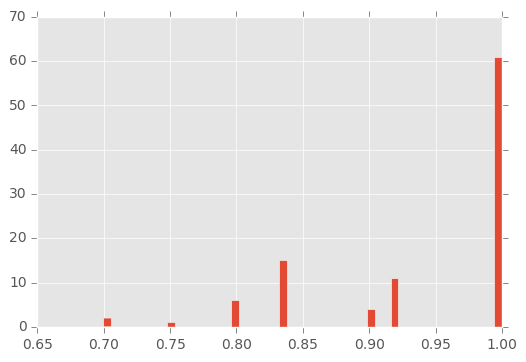

In [104]:
plt.hist(aucs, bins=50)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  10.,   0.,   0.,
          0.,  16.,   0.,   1.,   0.,  70.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

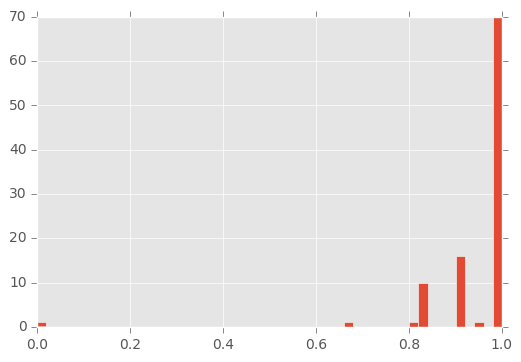

In [34]:
plt.hist(np.nan_to_num(aucs), bins=50)

In [84]:
np.mean(aucs)

0.94451984126984134

In [105]:
np.mean(aucs)

0.94133333333333336

In [40]:
roc_auc

1.0

In [44]:
logauc2(fpr, tpr, 0.001)

0.10034333188799373

In [36]:
np.mean(np.nan_to_num(aucs))

0.95299999999999996

In [ ]:
np.mean(aucs)

In [60]:
features.index.values.tolist().index("3p0g_lig")

34

In [34]:
sorted(delta_delta_g.columns.values)

['3p0g_lig',
 'Carvedilol',
 'Compound_A',
 'Compound_B',
 'Compound_C',
 'Compound_D',
 'Compound_E',
 'Compound_F',
 'Compound_G',
 'Compound_H',
 'Compound_I',
 'Compound_J',
 'Ici118551',
 'Ici215001',
 'Ici89406',
 'MAPE',
 'N-Cyclopentylbutanephrine',
 'Structure2D_CID_3343',
 'TERBSN',
 'Tulobuterol',
 'Xamoterol',
 'acebutolol',
 'adrenalone',
 'alprenalol',
 'bisoprolol',
 'cgp12177',
 'cimaterol',
 'clenbuterol',
 'clenproperol',
 'dichloroisopreterenol',
 'dobutamine',
 'dopamine',
 'du211117',
 'du28663',
 'epinine',
 'ethylnorepinephrine',
 'fenoterol',
 'formoterol',
 'hexoprenaline',
 'isoetharine',
 'isopropylnorsynephrine',
 'labetalol',
 'nebivolol',
 'nor-metanephrine',
 'norepinephrine',
 'orciprenaline',
 'pindolol',
 'practolol',
 'procaterol',
 'pronethalol',
 'propranolol',
 'r_epinephrine',
 'r_isopreterenol',
 'ritrodine',
 's-atenolol',
 's-carazolol',
 's-carvedilol',
 'salbutamol',
 'salmeterol',
 'skf42469',
 'sotalol',
 'sulfonterol',
 'ta-2005',
 'terbut

In [ ]:
n_exp = 100
aucs = [] 
for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1)
    common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]
    shuffle(common_ligands)
    X = delta_delta_g[common_ligands].values
    X = np.vstack([X, scale(X)]).T
    #X = scale(X).T
    y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))
    threshold = 0.2
    y = binarize(y, threshold=threshold)
    nb_train = 0.8 * np.shape(X)[0]
    
    X_train = X[:nb_train,:]
    y_train = y[:nb_train,:]
    X_test = X[nb_train:,:]
    y_test = y[nb_train:,:]
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_test)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)

    aucs.append(roc_auc)

In [427]:
delta_delta_g.columns.values

array(['timolol', 'isopropylnorsynephrine', 'Compound_B', 'Compound_H',
       'labetalol', 'cimaterol', 'ethylnorepinephrine', 's-carazolol',
       'fenoterol', 'pindolol', 'formoterol', 'du28663', 'Compound_E',
       'Ici215001', 's-atenolol', 'sotalol', 'pronethalol', 'Tulobuterol',
       'practolol', 'ritrodine', 'Ici118551', 'Carvedilol', 'Compound_A',
       'MAPE', 'orciprenaline', 'terbutaline', 'TERBSN', 'procaterol',
       'sulfonterol', 'r_epinephrine', 'Compound_F', 'norepinephrine',
       '3p0g_lig', 'clenproperol', 'alprenalol', 'skf42469', 'Compound_D',
       'epinine', 'salmeterol', 'hexoprenaline', 'Ici89406', 'ta-2005',
       'nebivolol', 'propranolol', 'Compound_I', 'Compound_C',
       'Compound_G', 'bisoprolol', 's-carvedilol', 'xamoterol',
       'isoetharine', 'du211117', 'Xamoterol', 'clenbuterol',
       'N-Cyclopentylbutanephrine', 'nor-metanephrine', 'adrenalone',
       'salbutamol', 'dichloroisopreterenol', 'r_isopreterenol',
       'dobutamine', 'cg

In [37]:
def b(x, y, i):
    return y[i+1] - x[i+1] * (y[i+1] - y[i]) / (x[i+1] - x[i])

def logauc(x, y, lam=0.001):
    num = 0.
    for i in range(0, len(x)-1):
        if x[i] >= lam:
            num += ((y[i+1]-y[i])/np.log(10) + b(x, y, i) * (np.log10(x[i+1]) - np.log10(x[i])))
    return num / (np.log10(1./lam))

In [45]:
fpr

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  1. ])

In [46]:
tpr

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1. ,  1. ])

In [50]:
aucs[99]

1.0

In [48]:
roc_auc

1.0

In [41]:
def logauc2(x, y, lam=0.001):
    num = 0.
    for i in range(0, len(x)-1):
        if x[i] >= lam:
            num += (np.log10(x[i+1]) - np.log10(x[i])) * (y[i+1]+y[i]) /2.
    return num / (np.log10(1./lam))

In [281]:
bret = pd.read_csv("/home/enf/b2ar_analysis/bias_analysis/bret_bias_study.csv", header=0).dropna().set_index("EvanName")
bret

Number  \
EvanName                         
adrenalone                   1   
salbutamol                   4   
alprenalol                   5   
s-atenolol                   6   
bisoprolol                   7   
Tulobuterol                  9   
Carvedilol                  10   
cgp12177                    11   
cimaterol                   12   
clenbuterol                 13   
dichloroisopreterenol       14   
dobutamine                  15   
dopamine                    16   
du211117                    17   
du28663                     18   
r_epinephrine               19   
fenoterol                   20   
hexoprenaline               21   
Ici118551                   22   
Ici215001                   23   
Ici89406                    24   
isopropylnorsynephrine      25   
r_isopreterenol             26   
labetalol                   27   
MAPE                        28   
clenproperol                29   
epinine                     30   
norepinephrine              31   
nor-metanephrine            32   
orciprenaline               33   
pindolol                    34   
practolol                   35   
pronethalol                 36   
propranolol                 37   
ritrodine                   38   
skf42469                    39   
sotalol                     40   
sulfonterol                 41   
terbutaline                 42   
TERBSN                      43   
timolol                     44   
xamoterol                   45   

                                                                     Name  \
EvanName                                                                    
adrenalone                                                     Adrenalone   
salbutamol                                         Albuterol (Salbutamol)   
alprenalol                                                     Alprenolol   
s-atenolol                                                       Atenolol   
bisoprolol                                                     Bisoprolol   
Tulobuterol                                             C78 (Tulobuterol)   
Carvedilol                                                     Carvedilol   
cgp12177                                                        CGP 12177   
cimaterol                                                       Cimeterol   
clenbuterol                                                   Clenbuterol   
dichloroisopreterenol                               Dichloroisoproterenol   
dobutamine                                                     Dobutamine   
dopamine                                                         Dopamine   
du211117                                                         Du 21117   
du28663                                                          Du 28663   
r_epinephrine                                                 Epinephrine   
fenoterol                                                       Fenoterol   
hexoprenaline                                               Hexoprenaline   
Ici118551                                                      ICI 118551   
Ici215001                                                      ICI 215001   
Ici89406                                                        ICI 89406   
isopropylnorsynephrine                             Isopropylnorsynephrine   
r_isopreterenol                                             Isoproterenol   
labetalol                                                       Labetalol   
MAPE                    MAPE [2-(methylamino)-1-\rphenylethanol]\rhalo...   
clenproperol                                       NAB 277 (clenproperol)   
epinine                                       N-methyl-dopamine (epinine)   
norepinephrine                                             Norepinephrine   
nor-metanephrine                                         Nor-metanephrine   
orciprenaline                                     Orciprenaline (alupent)   
pindolol                                                       

In [292]:
common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]

(42, 164)
(42, 1)
[[ 0.4  0.6]
 [ 0.5  0.5]
 [ 0.7  0.3]
 [ 0.1  0.9]
 [ 0.4  0.6]
 [ 0.4  0.6]
 [ 0.9  0.1]
 [ 0.1  0.9]
 [ 0.1  0.9]]
[ 0.   0.2  0.4  0.6  0.8  1. ]
[ 0.   0.5  1.   1.   1.   1. ]


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DataConversionWarning: A column-vector 

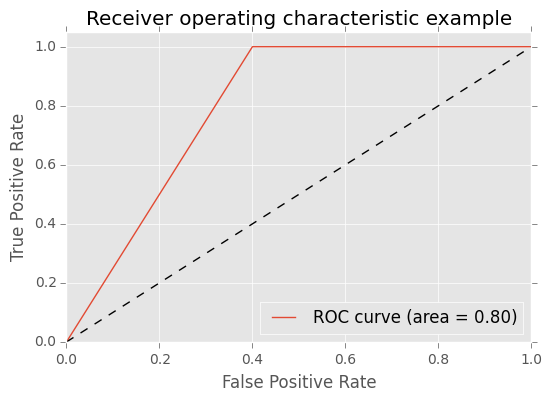

In [283]:
from sklearn.preprocessing import binarize
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from random import shuffle
from sklearn.metrics import roc_curve, auc
rfc = RandomForestClassifier(n_estimators=10, max_features='sqrt', n_jobs=-1)
common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]
shuffle(common_ligands)
X = delta_delta_g[common_ligands].values
X = np.vstack([X, scale(X)]).T
#X = scale(X).T
print(np.shape(X))
y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))
threshold = 0.2
y = binarize(y, threshold=threshold)
print(np.shape(y))
nb_train = 0.8 * np.shape(X)[0]
X_train = X[:nb_train,:]
y_train = y[:nb_train,:]
X_test = X[nb_train:,:]
y_test = y[nb_train:,:]
rfc.fit(X_train,y_train)
y_score = rfc.predict_proba(X_test)
print(y_score)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
print(fpr)
print(tpr)
roc_auc = auc(fpr, tpr)


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

In [128]:
logauc(fpr, tpr, lam=0.01)

0.23856062735983125

In [84]:
n_exp = 100
aucs = [] 
for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1)
    common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]
    shuffle(common_ligands)
    X = delta_delta_g[common_ligands].values
    X = np.vstack([X, scale(X)]).T
    #X = scale(X).T
    y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))
    threshold = 0.2
    y = binarize(y, threshold=threshold)
    nb_train = 0.8 * np.shape(X)[0]
    
    X_train = X[:nb_train,:]
    y_train = y[:nb_train,:]
    X_test = X[nb_train:,:]
    y_test = y[nb_train:,:]
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_test)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)

    aucs.append(roc_auc)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: DataConversionWarning: A column-vector 

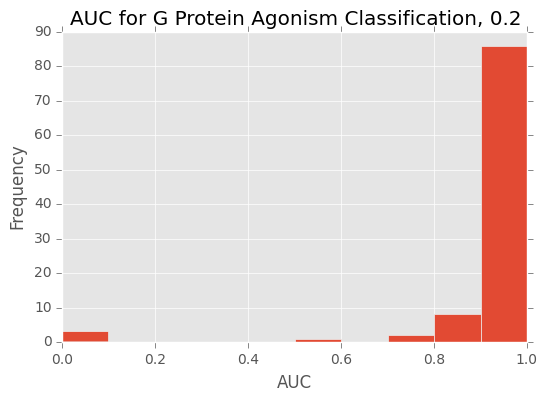

In [86]:
plt.hist(np.nan_to_num(aucs))
plt.title("AUC for G Protein Agonism Classification, 0.2")
plt.xlabel("AUC")
plt.ylabel("Frequency")

In [397]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from random import shuffle
rfr = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs=-1)
shuffle(common_ligands)
X = delta_delta_g[common_ligands].values.T
#X = np.vstack([X, scale(X)]).T
#X = scale(X).T
print(np.shape(X))
y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))
print(np.shape(y))
nb_train = 0.8 * np.shape(X)[0]
X_train = X[:nb_train,:]
y_train = y[:nb_train,:]
X_test = X[nb_train:,:]
y_test = y[nb_train:,:]
rfr.fit(X_train,y_train)
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

(42, 100)
(42, 1)


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DataConversionWarning: A column-vector 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [398]:
rfr.predict(X)

array([ 0.64962,  0.52581,  0.52949,  0.04726,  0.82301,  0.12869,
        0.10853,  0.03347,  0.67696,  0.08576,  0.8276 ,  0.93871,
        0.822  ,  0.60588,  0.88059,  0.80571,  0.00836,  0.05142,
        0.11445, -0.00854,  0.77407,  0.95509,  0.54073,  0.84179,
        0.91865,  0.0745 ,  0.90663,  0.30182,  0.7994 ,  0.24734,
        0.20711,  0.03208,  0.04125,  0.70984,  0.81574,  0.31966,
        0.65514,  0.28083,  0.63203,  0.68429,  0.77588,  0.13556])

In [400]:
from matplotlib.backends.backend_pdf import PdfPages

plt.scatter(rfr.predict(X_train),y_train)
plt.xlabel("Predicted G Protein Activity")
plt.ylabel("Experimental G Protein Activity")
plt.title("Random Forest Regression for G Protein Activity: Train")

pp = PdfPages("%s/gprot_rfr_train.pdf" % docking_dir)
pp.savefig(bbox_inches='tight')
pp.close()
plt.clf()


In [401]:
plt.scatter(rfr.predict(X_test),y_test)
plt.xlabel("Predicted G Protein Activity")
plt.ylabel("Experimental G Protein Activity")
plt.title("Random Forest Regression for G Protein Activity: Test")

pp = PdfPages("%s/gprot_rfr_test.pdf" % docking_dir)
pp.savefig(bbox_inches='tight')
pp.close()
plt.clf()

In [121]:
np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1)))))


NameError: name 'rfr' is not defined

In [134]:
null_features

sample                     2rh1_grid  3p0g_grid  null_scores
timolol                         7.84       7.61        -0.23
isopropylnorsynephrine          7.08       9.28         2.20
Compound_B                      9.61       7.65        -1.96
Compound_H                      7.39       8.17         0.78
labetalol                       8.73      10.24         1.51
cimaterol                       7.57       9.18         1.61
ethylnorepinephrine             7.25       9.47         2.22
s-carazolol                    10.28       6.50        -3.78
olodaterol                      8.61      10.55         1.94
ah3474                          7.76      10.04         2.28
fenoterol                       7.85      10.55         2.70
pindolol                        8.26       6.80        -1.46
formoterol                      8.45       9.74         1.29
du28663                         7.57       9.10         1.53
Compound_E                      9.51       8.05        -1.46
Ici215001                       7.87       7.19        -0.68
acebutolol                      5.69       5.10        -0.59
s-atenolol                      7.90       4.82        -3.08
sotalol                         8.16       6.31        -1.85
pronethalol                     8.91       7.65        -1.26
Tulobuterol                     7.58       8.71         1.13
practolol                       5.49       3.29        -2.20
ritrodine                       6.88       8.82         1.94
Ici118551                       8.16       6.56        -1.60
Carvedilol                     11.09       8.02        -3.07
Compound_A                      9.00       8.24        -0.76
MAPE                            6.82       8.10         1.28
orciprenaline                   6.90       9.16         2.26
Structure2D_CID_3343            8.39       9.77         1.38
cicloprolol                     8.40       4.37        -4.03
...                              ...        ...          ...
ta-2005                         9.46      11.14         1.68
nebivolol                       9.20       7.99        -1.21
bupranolol                      8.06       5.62        -2.44
propranolol                     9.63       7.25        -2.38
Compound_I                      9.73       7.52        -2.21
Compound_C                      8.87       7.78        -1.09
ah3021                          7.42       9.66         2.24
Compound_G                      9.22       8.13        -1.09
bisoprolol                      9.50       6.06        -3.44
s-carvedilol                   10.43       7.24        -3.19
xamoterol                       8.66       8.28        -0.38
isoetharine                     7.01       9.60         2.59
du211117                        7.50       9.54         2.04
Xamoterol                       8.83       7.06        -1.77
clenbuterol                     7.61       9.41         1.80
zinterol                        8.89      11.30         2.41
N-Cyclopentylbutanephrine       7.51       9.81         2.30
nor-metanephrine                7.62       7.41        -0.21
adrenalone                      6.35       8.44         2.09
salbutamol                      6.38       9.02         2.64
dichloroisopreterenol           8.30       8.29        -0.01
r_isopreterenol                 7.15       9.29         2.14
broxaterol                      6.71       7.55         0.84
bevantolol                      8.53       7.41        -1.12
dobutamine                      7.43       9.93         2.50
cgp12177                        8.56       6.91        -1.65
nipradilol                      8.23       5.86        -2.37
bucindolol                     10.26       8.20        -2.06
dopamine                        6.86       8.01         1.15
Compound_J                     10.13       7.62        -2.51

[80 rows x 3 columns]

In [295]:
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

test_accuracies = []
test_r2s = []
C_test_accuracies = []
C_test_r2s = []

for j in range(0,10):
    n_exp = 1
    accuracies = []
    r2s = []
    importances = []

    gbr_accuracies = []
    gbr_r2s = []
    gbr_importances = []

    oob_scores = []

    C_accuracies = []
    C_r2s = []
    C_importances = []
    C_oob_scores = []

    C_gbr_accuracies = []
    C_gbr_r2s = []
    C_gbr_importances = []

    X = delta_delta_g[common_ligands].values.T
    C = null_features.loc[common_ligands].values
    y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))

    X, X_pristine, y, y_pristine, C, C_pristine = train_test_split(X, y, C, train_size=0.7)

    X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
    

    
    for i in range(0, n_exp):
        X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
        sc = StandardScaler()
        sc.fit(X_train)
        X_train = np.hstack([X_train, sc.transform(X_train)])
        X_test = np.hstack([X_test, sc.transform(X_test)])

        sc = StandardScaler()
        sc.fit(C_train)
        C_train = np.hstack([C_train, sc.transform(C_train)])
        C_test = np.hstack([C_test, sc.transform(C_test)])

        rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
        rfr.fit(X_train,y_train)
        accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
        r2s.append(r2_score(y_test, rfr.predict(X_test)))
        importances.append(rfr.feature_importances_)
        oob_scores.append(rfr.oob_score_)
    mean_importances = np.mean(np.vstack(importances), axis=0)
    top_features = np.argsort(-1.0*mean_importances)[0:5]
    print(top_features)

    sc = StandardScaler()
    sc.fit(X)
    X_train = np.hstack([X, sc.transform(X)])
    X_test = np.hstack([X_pristine, sc.transform(X_pristine)])

    sc = StandardScaler()
    sc.fit(C)
    C_train = np.hstack([C, sc.transform(C)])
    C_test = np.hstack([C_pristine, sc.transform(C_pristine)])

    y_train = y
    y_test = y_pristine

    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train)
    test_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
    test_r2s.append(r2_score(y_test, rfr.predict(X_test)))

    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(C_train, y_train)
    C_test_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(C_test).reshape((-1,1))))))
    C_test_r2s.append(r2_score(y_test, rfr.predict(C_test)))

    
    

    

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

[176  92 144  44  76]
[104  92 192  44 144]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[176 183  76  83 144]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


[ 83 176  76 104   4]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[144  44 183  76   8]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


[ 76  83   4 183 176]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[144  44 192  83 183]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


[176  76 139 104  83]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[144  44  83  76   6]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


[ 83 104 183  44 106]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [296]:
print(np.mean(test_accuracies))
print(np.mean(test_r2s))
print(np.mean(C_test_accuracies))
print(np.mean(C_test_r2s))

0.244580457165
0.646525979413
0.275746922422
0.528082482886


In [294]:
print(np.mean(test_accuracies))
print(np.mean(test_r2s))
print(np.mean(C_test_accuracies))
print(np.mean(C_test_r2s))

0.223426356348
0.653087055995
0.274383241665
0.461283320556


In [254]:
print(np.median(accuracies))
print(np.median(r2s))

0.300962057358
0.0325358508387


In [255]:
mean_importances = np.mean(np.vstack(importances), axis=0)
top_features = np.argsort(-1.0*mean_importances)[0:10]
print(top_features)

sc = StandardScaler()
sc.fit(X)
X_train = np.hstack([X, sc.transform(X)])
X_test = np.hstack([X_pristine, sc.transform(X_pristine)])

sc = StandardScaler()
sc.fit(C)
C_train = np.hstack([C, sc.transform(C)])
C_test = np.hstack([C_pristine, sc.transform(C_pristine)])

y_train = y
y_test = y_pristine

rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
rfr.fit(X_train, y_train)
print("RMSE:")
print(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
print("r2_score:")
print(r2_score(y_test, rfr.predict(X_test)))

rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
rfr.fit(C_train, y_train)
print("RMSE:")
print(np.sqrt(np.mean(np.square(y_test-rfr.predict(C_test).reshape((-1,1))))))
print("r2_score:")
print(r2_score(y_test, rfr.predict(C_test)))
#importances.append(rfr.feature_importances_)
#oob_scores.append(rfr.oob_score_)


[ 80 180  99 199  13 113 144  44 116 177]
RMSE:
0.485001829522
r2_score:
-0.103853543192

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RMSE:
0.478874504312
r2_score:
-0.0761384112325


In [252]:
 np.argsort(-1.0*mean_importances)

array([113,  13, 144,  80, 199, 180,  44, 138,  38,  99,  43, 104,  60,
         4, 177,  77, 143, 160, 109,  21, 121,  84, 193,   9, 161, 184,
       116,  16,  87,  93,  61, 108,  65,   8,  39, 139,  83,  92, 196,
       165, 187,   6,  94, 194, 115, 192,  75,  15, 183, 175,  96, 106,
       198,  58, 176,  76,  79,  40, 120, 118, 101, 137, 158, 136,  20,
        36,  98,  18, 164,  29, 140,  82,  64,  88, 150,  37,  74, 182,
       103, 179, 114, 178, 162,  50, 126,   1, 169, 188, 147, 186,  62,
        55,  24,  78, 130,  69, 123, 129,  34, 174,  14,  85,  22, 145,
       159,   3,  51, 195,  95,  28,  47, 134, 155,  45, 128, 142, 190,
        59, 185,  35, 112,  63,  56,  86, 131,   0,  33, 122, 124,  12,
        41, 141, 163, 135,  90,  57, 157,  73, 117, 151,  31,  89,  26,
        42,  23, 146, 156, 133,  68,  11,   7, 127, 191, 111,  30, 168,
       173,  46, 100,  91, 132, 148, 149,   2, 102,  17,  27, 110, 167,
        25, 105, 197,  72,  32,   5,  71,  10,  49, 171, 172, 10

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,
         2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
         2.,  2.,  3.,  1.,  4.,  0.,  1.,  0.,  1.,  0.,  6.,  2.,  2.,
         9.,  3.,  5.,  9.,  5.,  6.,  5.,  4.,  2.]),
 array([ -1.58861445e+00,  -1.56299700e+00,  -1.53737955e+00,
         -1.51176211e+00,  -1.48614466e+00,  -1.46052721e+00,
         -1.43490976e+00,  -1.40929232e+00,  -1.38367487e+00,
         -1.35805742e+00,  -1.33243997e+00,  -1.30682253e+00,
         -1.28120508e+00,  -1.25558763e+00,  -1.22997019e+00,
         -1.20435274e+00,  -1.17873529e+00,  -1.15311784e+00,
         -1.12750040e+00,  -1.10188295e+00,  -1.07626550e+00,


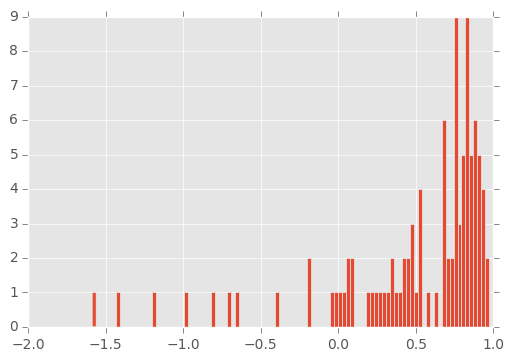

In [190]:
plt.hist(C_r2s, bins=100)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,
          2.,   1.,   2.,   4.,   7.,   4.,  12.,  15.,  10.,  12.,  14.,
         10.]),
 array([-5.96609207, -5.89715644, -5.82822081, -5.75928517, -5.69034954,
        -5.62141391, -5.55247827, -5.48354264, -5.414607  , -5.34567137,
        -5.27673574, -5.2078001 , -5.13886447, -5.06992884, -5.0009932 ,
        -4.93205757, -4.86312194, -4.7941863 , -4.72525067, -4.65631503,
        -4.5873794 , -4.51

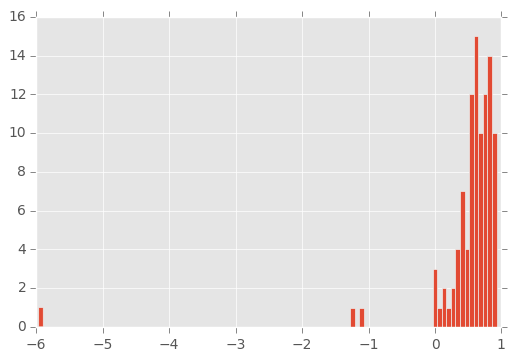

In [191]:
plt.hist(r2s, bins=100)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


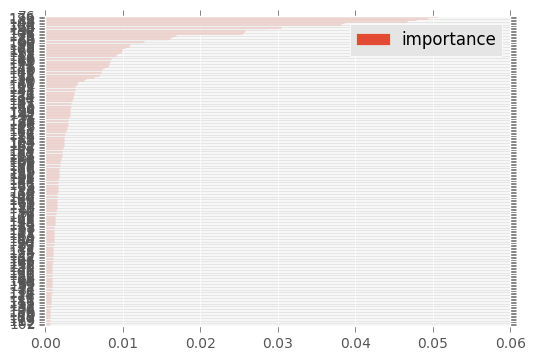

In [186]:
pd.DataFrame(np.mean(np.vstack(importances), axis=0), columns=["importance"]).sort("importance",inplace=False).plot(kind='barh')

In [174]:
np.median(oob_scores)

0.66686800986406047

In [173]:
np.median(C_oob_scores)

0.52264248327633533

In [175]:
np.mean(C_r2s)

0.4949713992637525

In [193]:
np.mean(C_r2s)

0.41459778308938233

In [176]:
np.mean(r2s)

0.51495603389295996

In [194]:
np.mean(r2s)

0.49596680059688608

In [177]:
np.mean(accuracies)

0.21615767596505669

In [195]:
np.mean(accuracies)

0.2641230025623118

In [179]:
np.median(accuracies)

0.20679896831949685

In [196]:
np.median(accuracies)

0.22625092578341072

In [178]:
np.mean(C_accuracies)

0.22033684349604399

In [197]:
np.mean(C_accuracies)

0.26969165617241853

In [180]:
np.median(C_accuracies)

0.19816650682560527

In [198]:
np.median(C_accuracies)

0.22558873864690387

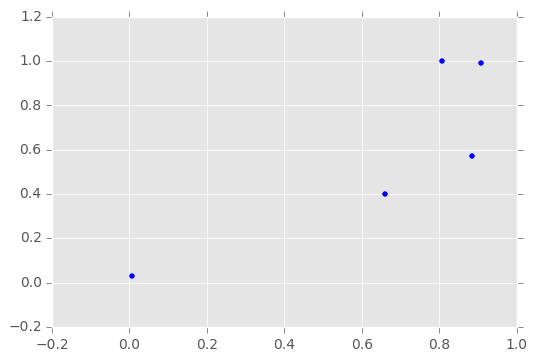

In [172]:
plt.scatter(rfr.predict(C_test),y_test)

In [88]:
med_importances = np.median(np.array(importances), axis=0)
gprot_importances_df = pd.DataFrame(med_importances, index=aggregate_docking_msm.index.values.tolist() + ["%s_scaled" %n for n in aggregate_docking_msm.index.values.tolist()], columns=["RFR Importance"]).sort("RFR Importance", ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [206]:
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import SparsePCA
n_exp = 5
accuracies = []
r2s = []
importances = []

gbr_accuracies = []
gbr_r2s = []
gbr_importances = []

oob_scores = []

C_accuracies = []
C_r2s = []
C_importances = []
C_oob_scores = []

C_gbr_accuracies = []
C_gbr_r2s = []
C_gbr_importances = []

X = delta_delta_g[common_ligands].iloc[[62, 80, 16, 61]].values.T
C = null_features.loc[common_ligands].values
y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))

for i in range(0, n_exp):
    X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = np.hstack([X_train, sc.transform(X_train)])
    X_test = np.hstack([X_test, sc.transform(X_test)])
    
    sc = StandardScaler()
    sc.fit(C_train)
    C_train = np.hstack([C_train, sc.transform(C_train)])
    C_test = np.hstack([C_test, sc.transform(C_test)])
    
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(X_train,y_train)
    accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
    r2s.append(r2_score(y_test, rfr.predict(X_test)))
    importances.append(rfr.feature_importances_)
    oob_scores.append(rfr.oob_score_)
    
    gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, init=None, random_state=None, max_features=None)
    gbr.fit(X_train,y_train)
    gbr_accuracies.append(np.sqrt(np.mean(np.square(y_test-gbr.predict(X_test).reshape((-1,1))))))
    gbr_r2s.append(r2_score(y_test, gbr.predict(X_test)))
    gbr_importances.append(gbr.feature_importances_)

    
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(C_train,y_train)
    C_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(C_test).reshape((-1,1))))))
    C_r2s.append(r2_score(y_test, rfr.predict(C_test)))
    C_importances.append(rfr.feature_importances_)
    C_oob_scores.append(rfr.oob_score_)
    
    gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, init=None, random_state=None, max_features=None)
    gbr.fit(C_train,y_train)
    C_gbr_accuracies.append(np.sqrt(np.mean(np.square(y_test-gbr.predict(C_test).reshape((-1,1))))))
    C_gbr_r2s.append(r2_score(y_test, gbr.predict(C_test)))
    
    

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

In [207]:
print(np.median(accuracies))
print(np.median(C_accuracies))
print(np.median(gbr_accuracies))
print(np.median(C_gbr_accuracies))



0.324424348285
0.407101751409
0.364296360631
0.514725338022


In [208]:
print(np.median(r2s))
print(np.median(C_r2s))
print(np.median(gbr_r2s))
print(np.median(C_gbr_r2s))


0.18471184495
-0.197192664611
0.178501010581
-0.824126769999


In [221]:
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import SparsePCA
n_exp = 10
accuracies = []
r2s = []
importances = []

gbr_accuracies = []
gbr_r2s = []
gbr_importances = []

oob_scores = []

C_accuracies = []
C_r2s = []
C_importances = []
C_oob_scores = []

C_gbr_accuracies = []
C_gbr_r2s = []
C_gbr_importances = []

X = delta_delta_g[common_ligands].iloc[[16, 80, 61, 62]].values.T
#spca = SparsePCA(n_components=20, alpha=2.)
X = spca.fit_transform(X)
print(spca.components_)
C = null_features.loc[common_ligands].values
y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))

for i in range(0, n_exp):
    X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C, train_size=0.9)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = np.hstack([X_train, sc.transform(X_train)])
    X_test = np.hstack([X_test, sc.transform(X_test)])
    
    sc = StandardScaler()
    sc.fit(C_train)
    C_train = np.hstack([C_train, sc.transform(C_train)])
    C_test = np.hstack([C_test, sc.transform(C_test)])
    
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(X_train,y_train)
    accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
    r2s.append(r2_score(y_test, rfr.predict(X_test)))
    importances.append(rfr.feature_importances_)
    oob_scores.append(rfr.oob_score_)
    
    gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, init=None, random_state=None, max_features=None)
    gbr.fit(X_train,y_train)
    gbr_accuracies.append(np.sqrt(np.mean(np.square(y_test-gbr.predict(X_test).reshape((-1,1))))))
    gbr_r2s.append(r2_score(y_test, gbr.predict(X_test)))
    gbr_importances.append(gbr.feature_importances_)

    
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, oob_score=True)
    rfr.fit(C_train,y_train)
    C_accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(C_test).reshape((-1,1))))))
    C_r2s.append(r2_score(y_test, rfr.predict(C_test)))
    C_importances.append(rfr.feature_importances_)
    C_oob_scores.append(rfr.oob_score_)
    
    gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, init=None, random_state=None, max_features=None)
    gbr.fit(C_train,y_train)
    C_gbr_accuracies.append(np.sqrt(np.mean(np.square(y_test-gbr.predict(C_test).reshape((-1,1))))))
    C_gbr_r2s.append(r2_score(y_test, gbr.predict(C_test)))
    
    

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[[-2.93690043 -3.15456965 -0.50394957  0.        ]
 [ 0.          0.          2.39246749  2.90525626]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.  

In [222]:
print(np.median(accuracies))
print(np.median(gbr_accuracies))
print(np.median(C_accuracies))
print(np.median(C_gbr_accuracies))
print(np.median(r2s))
print(np.median(C_r2s))

0.277005643687
0.39750744312
0.385861438181
0.436778153677
-0.349206825687
-0.701651653288


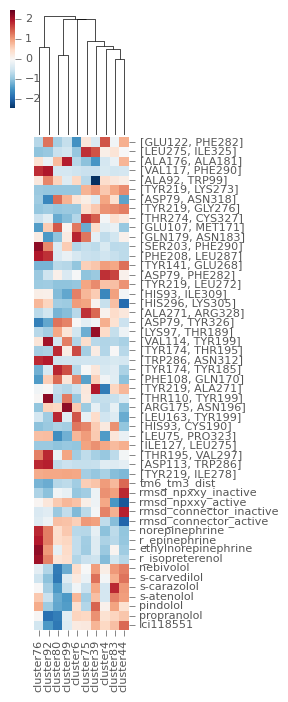

In [411]:
import plots
reload(plots)
from plots import *
names = [n.split("_scaled")[0] for n in gprot_importances_df.index.values.tolist()]
new_names = []
for n in names:
    if n not in new_names: new_names.append(n)
plot_clustermap(pd.concat([samples_top_features_avg_df, samples_pnas_avg_df, ddg_scaled[["norepinephrine", "r_epinephrine", "ethylnorepinephrine", "r_isopreterenol", "nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "pindolol", "propranolol", 'Ici118551']]],axis=1).loc[new_names[:10]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_arrestin_agonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=True, row_cluster=False, ytick_labelsize=8, xtick_labelsize=8)

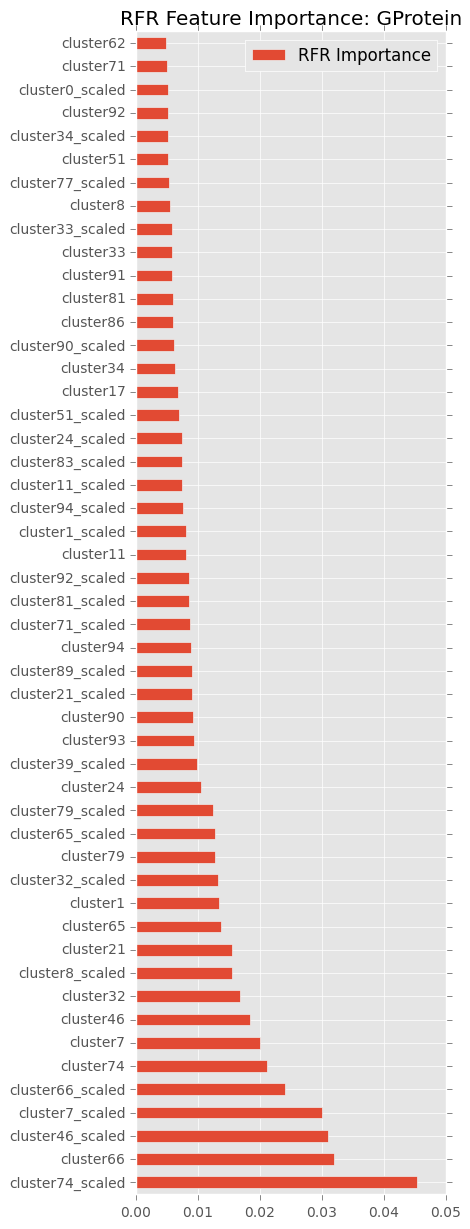

In [89]:
gprot_importances_df.iloc[0:50].plot(kind='barh', figsize=(4,15), title="RFR Feature Importance: GProtein")

(array([  7.,  10.,  29.,  12.,  16.,   7.,   9.,   5.,   3.,   2.]),
 array([ 0.13286777,  0.1578267 ,  0.18278564,  0.20774457,  0.2327035 ,
         0.25766243,  0.28262136,  0.30758029,  0.33253922,  0.35749815,
         0.38245708]),
 <a list of 10 Patch objects>)

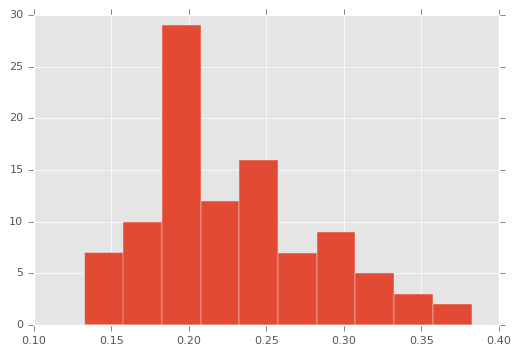

In [413]:
plt.hist(accuracies, bins=10)

In [59]:
agonist_indices

NameError: name 'agonist_indices' is not defined

In [405]:
importances_df = pd.DataFrame(rfr.feature_importances_, index=aggregate_docking_msm.index.values.tolist(),  columns=["RFR Importance"]).sort("RFR Importance", ascending=False)
                              #+ ["%s_scaled" %f for f in aggregate_docking_msm.index.values] ,

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [406]:
len(aggregate_docking_msm.index.values + ["%s_scaled" %f for f in aggregate_docking_msm.index.values])

100

In [408]:
deltas_tica.loc[importances_df.index][["r_isopreterenol", "bisoprolol", "tm6_tm3_dist", "rmsd_npxxy_active", "tIC.1"]].iloc[0:17]

r_isopreterenol  bisoprolol  tm6_tm3_dist  rmsd_npxxy_active  \
cluster83        -0.883231    0.076912     12.696894           0.568528   
cluster76         0.346369   -0.396688      6.934668           0.815826   
cluster99        -0.459631   -0.749088      8.386127           0.941357   
cluster6         -1.008431    0.146512      7.805265           0.925620   
cluster44        -0.989231   -0.129488     14.514004           0.459027   
cluster60        -0.544831   -0.256688      8.310465           0.875586   
cluster92        -0.071231   -0.601888      6.729899           0.856788   
cluster4         -1.162831   -0.431088     13.398596           0.963357   
cluster39        -0.900831    0.304112     12.366688           0.787174   
cluster47        -0.474431   -0.564288     11.011123           1.100978   
cluster75        -0.916831   -0.579888     12.123870           0.834489   
cluster8         -0.803231   -0.283488     12.980085           0.866111   
cluster13        -0.161231    0.104112     14.971719           1.002551   
cluster80        -0.503631   -0.833888      8.216347           0.911764   
cluster77        -0.504831   -0.339888     13.263500           0.795615   
cluster9         -0.361631   -0.501488      8.279215           1.017798   
cluster29        -0.901631   -0.135888     12.253496           0.874761   

                 tIC.1  
cluster83  -159.365355  
cluster76  -683.730955  
cluster99   520.380316  
cluster6    145.627003  
cluster44  -494.810147  
cluster60   106.271536  
cluster92  -395.669179  
cluster4    296.098198  
cluster39  -347.241052  
cluster47   469.300780  
cluster75  -742.170056  
cluster8  -1049.557984  
cluster13   199.273652  
cluster80   847.678785  
cluster77   123.117005  
cluster9    599.286681  
cluster29   566.681512

In [404]:
importances_df

RFR Importance
cluster16_scaled        0.030706
cluster62_scaled        0.022675
cluster38_scaled        0.022439
cluster13_scaled        0.020619
cluster6_scaled         0.020435
cluster99_scaled        0.020418
cluster44_scaled        0.019993
cluster80_scaled        0.019370
cluster80               0.018906
cluster44               0.018187
cluster4_scaled         0.017204
cluster13               0.015907
cluster99               0.015690
cluster21_scaled        0.014167
cluster83_scaled        0.011263
cluster60               0.011181
cluster75_scaled        0.010235
cluster39_scaled        0.010209
cluster77               0.009594
cluster38               0.009572
cluster43_scaled        0.009350
cluster84_scaled        0.008863
cluster4                0.008651
cluster21               0.008449
cluster79_scaled        0.008388
cluster94_scaled        0.007887
cluster84               0.007770
cluster16               0.007737
cluster15_scaled        0.007479
cluster60_scaled        0.007423
...                          ...
cluster32               0.001550
cluster54_scaled        0.001537
cluster32_scaled        0.001535
cluster73               0.001527
cluster5_scaled         0.001506
cluster78_scaled        0.001490
cluster48_scaled        0.001487
cluster7_scaled         0.001470
cluster56               0.001466
cluster54               0.001464
cluster52_scaled        0.001449
cluster7                0.001401
cluster70_scaled        0.001330
cluster30               0.001322
cluster71_scaled        0.001312
cluster30_scaled        0.001309
cluster2_scaled         0.001284
cluster46               0.001275
cluster52               0.001264
cluster81               0.001255
cluster19_scaled        0.001245
cluster70               0.001218
cluster12_scaled        0.001217
cluster66               0.001197
cluster97               0.001154
cluster19               0.001145
cluster67               0.001106
cluster66_scaled        0.000991
cluster46_scaled        0.000988
cluster10               0.000892

[200 rows x 1 columns]

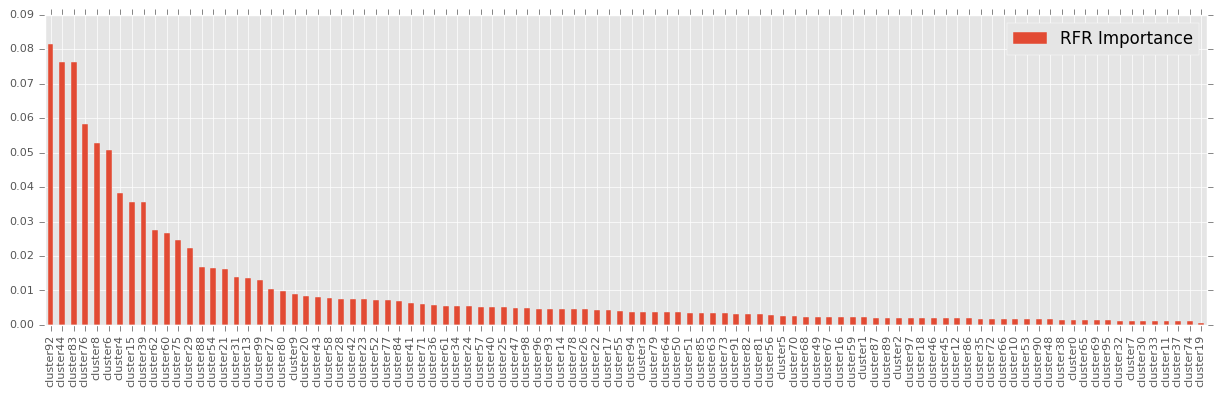

In [179]:
importances_df.plot(kind='bar', figsize=(15,4))

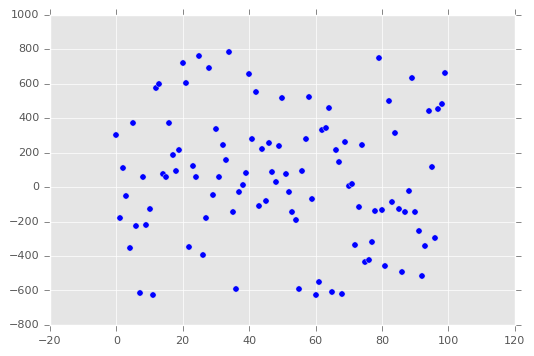

In [123]:
plt.scatter(range(0,100), deltas_tica.loc[importances_df.index]["tIC.2"].values)


we are operating on biox3


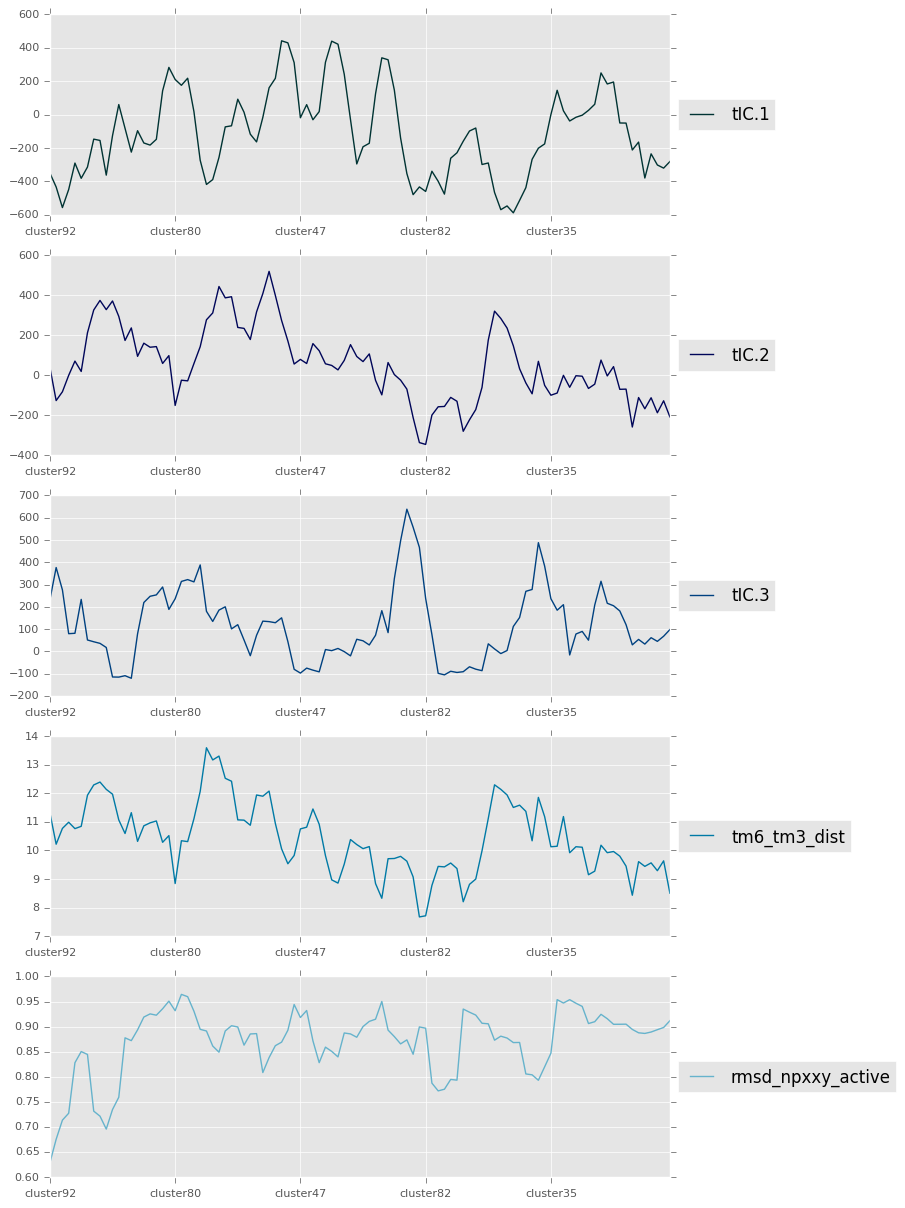

In [180]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plot_df_rolling(deltas_tica.loc[importances_df.index][["tIC.1", "tIC.2", "tIC.3", "tm6_tm3_dist", "rmsd_npxxy_active"]], "%s/tICA_vs_rfr_importance_agonists.pdf" %docking_dir, return_fig=True, subplots=True, smoothing=5, include_original=False)
#pd.rolling_mean(deltas_tica.loc[importances_df.index][["tIC.1", "tIC.2", "tIC.3", "tm6_tm3_dist", "rmsd_npxxy_active"]], 25).plot(colormap='gist_rainbow', subplots=True)



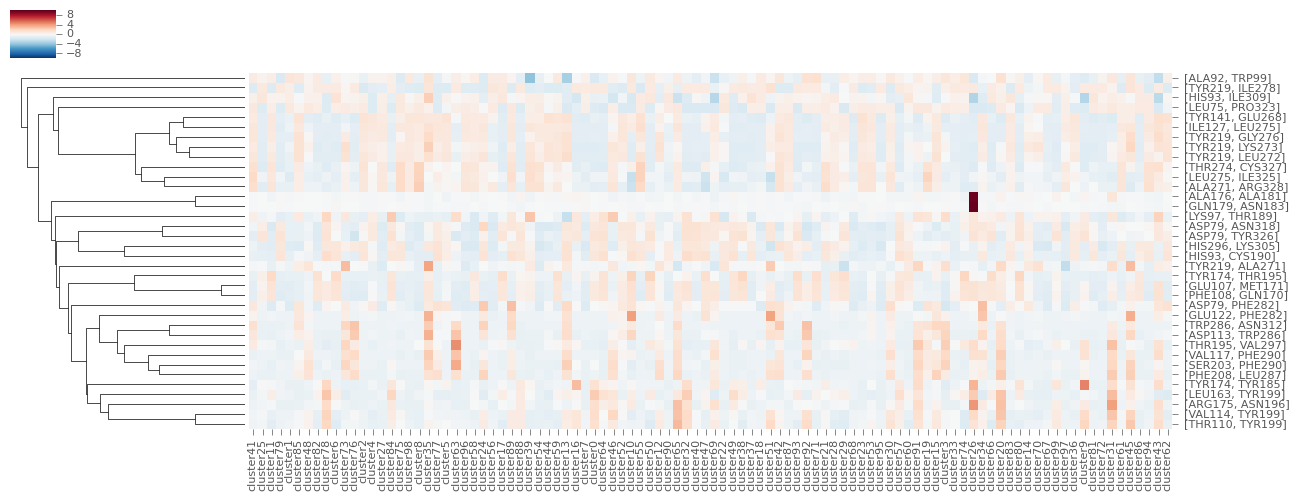

In [125]:
import plots
reload(plots)
from plots import *
#plot_df_rolling(samples_top_features_avg_df.loc[importances_df.index], "%s/features_vs_rfr_importance_arrestin_agonists.pdf" %docking_dir, return_fig=True, subplots=True, smoothing=5, include_original=False)
plot_clustermap(samples_top_features_avg_df.loc[importances_df.index].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_gprot_agonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=False)

#plot_clustermap(deltas_tica[["tm6_tm3_dist", "rmsd_npxxy_active", "3p0g_lig"]].loc[importances_df.index].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_gprot_agonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=False)



In [393]:
X = delta_delta_g[common_ligands].values.T
print(np.shape(X))
y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))
print(np.shape(y))
nb_train = int(0.8 * np.shape(X)[0])
X_train = X[:nb_train,:]
y_train = y[:nb_train,:]
X_test = X[nb_train:,:]
y_test = y[nb_train:,:]
rfr.fit(X_train,y_train)
print(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))

(42, 100)
(42, 1)
0.381273978073


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(42, 200)
(42, 1)
[[ 0.744  0.256]
 [ 0.713  0.287]
 [ 0.493  0.507]
 [ 0.872  0.128]
 [ 0.941  0.059]
 [ 0.707  0.293]
 [ 0.809  0.191]
 [ 0.803  0.197]
 [ 0.556  0.444]]
[ 0.   0.   0.   0.2  0.4  0.6  0.6  0.8  1. ]
[ 0.25  0.5   0.75  0.75  0.75  0.75  1.    1.    1.  ]


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector 

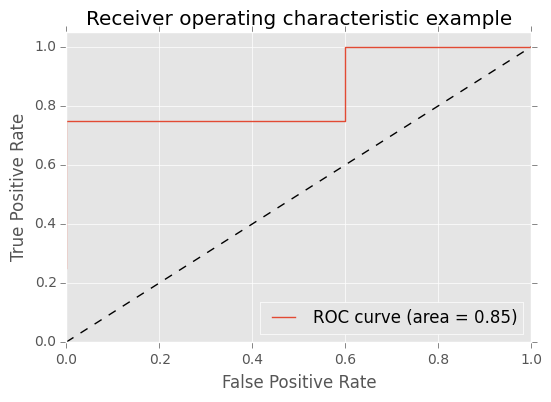

In [49]:
rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]
shuffle(common_ligands)
X = delta_delta_g[common_ligands].values
X = np.vstack([X, scale(X)]).T
#X = scale(X).T
print(np.shape(X))
y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))
threshold = 0.5
y = binarize(y, threshold=threshold)
print(np.shape(y))
nb_train = 0.8 * np.shape(X)[0]
X_train = X[:nb_train,:]
y_train = y[:nb_train,:]
X_test = X[nb_train:,:]
y_test = y[nb_train:,:]
rfc.fit(X_train,y_train)
y_score = rfc.predict_proba(X_test)
print(y_score)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
print(fpr)
print(tpr)
roc_auc = auc(fpr, tpr)


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

In [90]:
n_exp = 100
aucs = []
for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1)
    common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]
    shuffle(common_ligands)
    X = delta_delta_g[common_ligands].values
    X = np.vstack([X, scale(X)]).T
    #X = scale(X).T
    y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))
    threshold = 0.8
    y = binarize(y, threshold=threshold)
    nb_train = 0.8 * np.shape(X)[0]
    X_train = X[:nb_train,:]
    y_train = y[:nb_train,:]
    X_test = X[nb_train:,:]
    y_test = y[nb_train:,:]
    rfc.fit(X_train,y_train)
    y_score = rfc.predict_proba(X_test)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: DataConversionWarning: A column-vector 

In [91]:
aucs

[nan,
 nan,
 0.2857142857142857,
 1.0,
 0.73333333333333328,
 1.0,
 0.0,
 0.58333333333333326,
 1.0,
 0.4285714285714286,
 0.36666666666666664,
 0.83333333333333337,
 1.0,
 0.8571428571428571,
 0.58333333333333326,
 1.0,
 0.66666666666666663,
 0.5,
 0.66666666666666663,
 0.58333333333333326,
 0.125,
 nan,
 1.0,
 1.0,
 0.5,
 0.625,
 nan,
 nan,
 1.0,
 1.0,
 0.80000000000000004,
 1.0,
 0.83333333333333326,
 0.8571428571428571,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.66666666666666663,
 0.45833333333333337,
 0.53333333333333333,
 0.41666666666666663,
 0.8666666666666667,
 nan,
 0.875,
 1.0,
 0.099999999999999978,
 0.39999999999999991,
 1.0,
 0.79166666666666663,
 0.58333333333333326,
 0.35714285714285715,
 0.2857142857142857,
 0.83333333333333337,
 0.5625,
 0.4285714285714286,
 nan,
 nan,
 nan,
 0.36666666666666659,
 1.0,
 0.5,
 0.75,
 0.91666666666666663,
 0.5,
 1.0,
 0.5714285714285714,
 0.5,
 0.66666666666666663,
 0.73333333333333339,
 0.66666666666666663,
 0.54166666666666674,
 1.0,
 0.583333

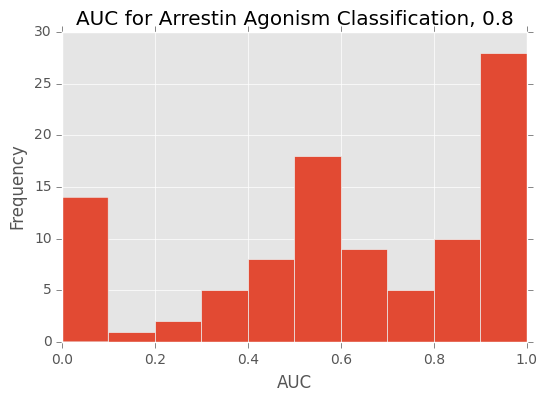

In [92]:
plt.hist(np.nan_to_num(aucs))
plt.title("AUC for Arrestin Agonism Classification, 0.8")
plt.xlabel("AUC")
plt.ylabel("Frequency")

In [182]:
importances_df = pd.DataFrame(rfr.feature_importances_, index=aggregate_docking_msm.index, columns=["RFR Importance"]).sort("RFR Importance", ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


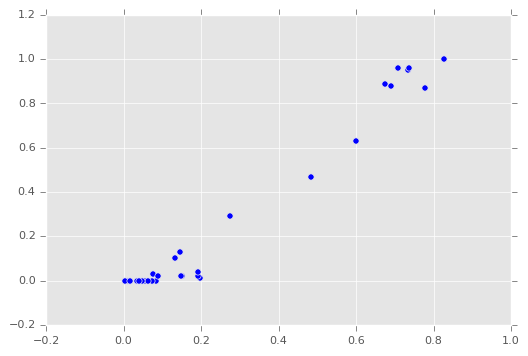

In [394]:
plt.scatter(rfr.predict(X_train),y_train)

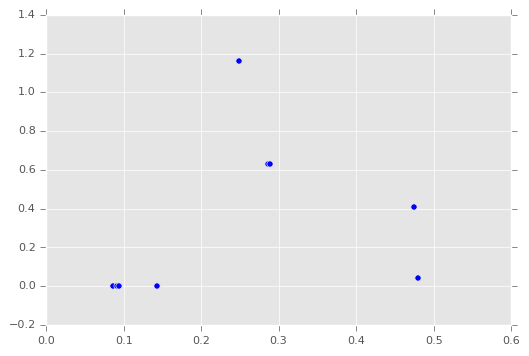

In [395]:
plt.scatter(rfr.predict(X_test),y_test)

In [185]:
pd.DataFrame(rfr.feature_importances_, index=aggregate_docking_msm.index, columns=["RFR Importance"]).sort("RFR Importance", ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


RFR Importance
cluster44        0.067168
cluster21        0.044780
cluster80        0.042325
cluster4         0.039220
cluster84        0.032581
cluster60        0.029213
cluster83        0.027945
cluster8         0.025514
cluster39        0.023686
cluster77        0.022037
cluster15        0.021903
cluster75        0.020996
cluster6         0.018403
cluster99        0.017433
cluster78        0.016972
cluster13        0.016635
cluster92        0.015576
cluster62        0.015213
cluster55        0.014937
cluster43        0.013956
cluster94        0.013598
cluster76        0.013420
cluster47        0.013319
cluster14        0.012894
cluster20        0.012458
cluster3         0.012242
cluster88        0.011141
cluster64        0.010339
cluster1         0.009987
cluster38        0.009444
...                   ...
cluster0         0.004681
cluster85        0.004221
cluster59        0.004118
cluster89        0.004051
cluster98        0.004025
cluster51        0.004017
cluster65        0.004010
cluster7         0.003691
cluster12        0.003655
cluster17        0.003496
cluster2         0.003429
cluster11        0.003419
cluster73        0.003233
cluster90        0.003107
cluster19        0.003019
cluster28        0.002948
cluster27        0.002912
cluster82        0.002835
cluster53        0.002755
cluster32        0.002688
cluster30        0.002655
cluster66        0.002635
cluster10        0.002514
cluster86        0.002465
cluster69        0.002437
cluster97        0.002320
cluster70        0.002317
cluster46        0.002087
cluster74        0.001885
cluster67        0.001774

[100 rows x 1 columns]

In [378]:
n_exp = 100
accuracies = []
r2s = []
importances = []
for i in range(0, n_exp):
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
    shuffle(common_ligands)
    X = delta_delta_g[common_ligands].values
    X = np.vstack([X, scale(X)]).T
    y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))
    nb_train = int(0.8 * np.shape(X)[0])
    X_train = X[:nb_train,:]
    y_train = y[:nb_train,:]
    X_test = X[nb_train:,:]
    y_test = y[nb_train:,:]
    rfr.fit(X_train,y_train)
    accuracies.append(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))
    r2s.append(rfr.score(X_test, y_test))
    importances.append(rfr.feature_importances_)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

(array([  5.,   8.,  12.,  16.,  17.,  18.,  13.,   6.,   3.,   2.]),
 array([ 0.16282203,  0.19780377,  0.23278551,  0.26776725,  0.30274899,
         0.33773072,  0.37271246,  0.4076942 ,  0.44267594,  0.47765768,
         0.51263942]),
 <a list of 10 Patch objects>)

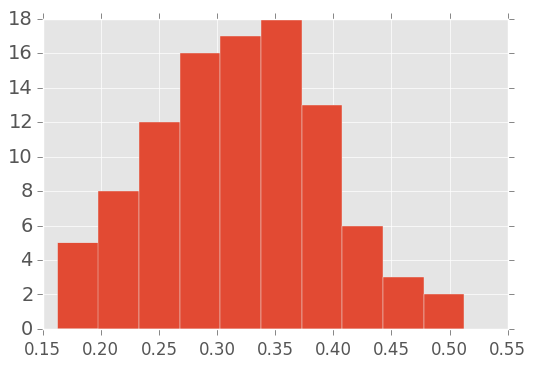

In [379]:
plt.hist(accuracies, bins=10)

{'boxes': [<matplotlib.lines.Line2D at 0x7f2d45ff2950>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2d45002e90>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2d45020850>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2d45ff20d0>,
  <matplotlib.lines.Line2D at 0x7f2d450022d0>]}

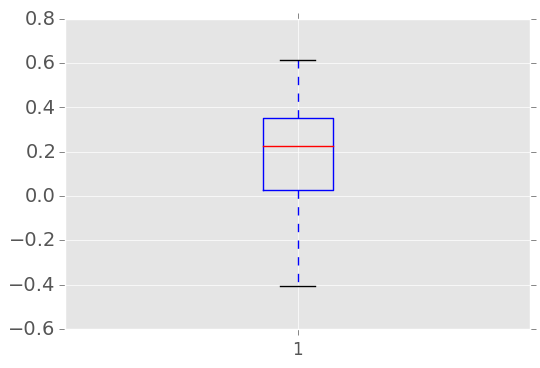

In [380]:
plt.boxplot(r2s, showfliers=False)
            

In [381]:
med_importances = np.median(np.array(importances), axis=0)
importances_df = pd.DataFrame(med_importances, index=aggregate_docking_msm.index.values.tolist() + ["%s_scaled" %n for n in aggregate_docking_msm.index.values.tolist()], columns=["RFR Importance"]).sort("RFR Importance", ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [382]:
importances_df

RFR Importance
cluster16_scaled        0.030706
cluster62_scaled        0.022675
cluster38_scaled        0.022439
cluster13_scaled        0.020619
cluster6_scaled         0.020435
cluster99_scaled        0.020418
cluster44_scaled        0.019993
cluster80_scaled        0.019370
cluster80               0.018906
cluster44               0.018187
cluster4_scaled         0.017204
cluster13               0.015907
cluster99               0.015690
cluster21_scaled        0.014167
cluster83_scaled        0.011263
cluster60               0.011181
cluster75_scaled        0.010235
cluster39_scaled        0.010209
cluster77               0.009594
cluster38               0.009572
cluster43_scaled        0.009350
cluster84_scaled        0.008863
cluster4                0.008651
cluster21               0.008449
cluster79_scaled        0.008388
cluster94_scaled        0.007887
cluster84               0.007770
cluster16               0.007737
cluster15_scaled        0.007479
cluster60_scaled        0.007423
...                          ...
cluster32               0.001550
cluster54_scaled        0.001537
cluster32_scaled        0.001535
cluster73               0.001527
cluster5_scaled         0.001506
cluster78_scaled        0.001490
cluster48_scaled        0.001487
cluster7_scaled         0.001470
cluster56               0.001466
cluster54               0.001464
cluster52_scaled        0.001449
cluster7                0.001401
cluster70_scaled        0.001330
cluster30               0.001322
cluster71_scaled        0.001312
cluster30_scaled        0.001309
cluster2_scaled         0.001284
cluster46               0.001275
cluster52               0.001264
cluster81               0.001255
cluster19_scaled        0.001245
cluster70               0.001218
cluster12_scaled        0.001217
cluster66               0.001197
cluster97               0.001154
cluster19               0.001145
cluster67               0.001106
cluster66_scaled        0.000991
cluster46_scaled        0.000988
cluster10               0.000892

[200 rows x 1 columns]

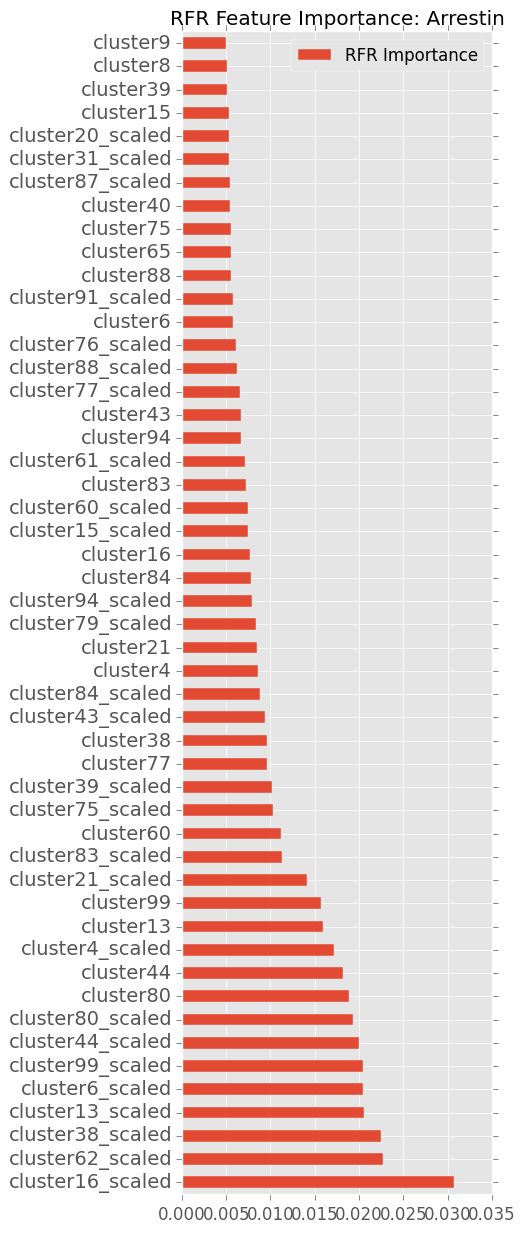

In [383]:
importances_df.iloc[0:50].plot(kind='barh', figsize=(4,15), title="RFR Feature Importance: Arrestin")

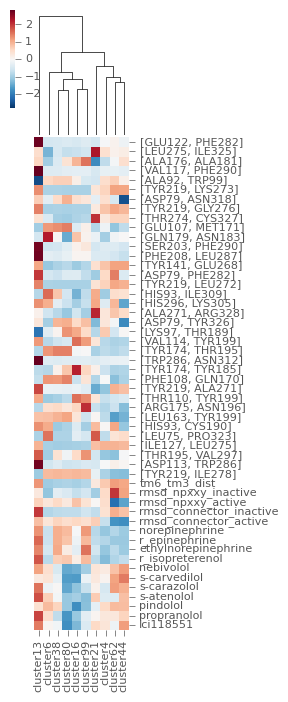

In [391]:
import plots
reload(plots)
from plots import *
names = [n.split("_scaled")[0] for n in importances_df.index.values.tolist()]
new_names = []
for n in names:
    if n not in new_names: new_names.append(n)
plot_clustermap(pd.concat([samples_top_features_avg_df, samples_pnas_avg_df, ddg_scaled[["norepinephrine", "r_epinephrine", "ethylnorepinephrine", "r_isopreterenol", "nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "pindolol", "propranolol", 'Ici118551']]],axis=1).loc[new_names[:10]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_arrestin_agonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=True, row_cluster=False, ytick_labelsize=8, xtick_labelsize=8)

In [329]:
ddg_scaled[["r_isopreterenol", "salbutamol"]]

r_isopreterenol  salbutamol
78        -0.781076   -1.372927
80        -0.268739   -0.701981
16        -0.600580   -1.068881
74        -0.141731   -0.887198
26        -0.199136   -0.783060
51         0.858545    0.576683
99        -0.189808   -0.092031
0         -0.770312   -1.210769
84         0.229964   -0.417834
49        -0.643305   -1.003237
43        -0.302464   -0.362046
92         0.506942    0.378821
69        -0.523472   -0.728016
38        -0.315380   -0.303282
87        -0.903061   -0.847031
64        -0.722954   -1.047124
77        -0.270892   -0.964558
9         -0.014006    0.239723
40        -0.778923   -0.691568
50        -0.349106   -0.170134
32        -0.235731   -0.632804
65        -0.438083   -0.983898
79        -0.629671   -0.391799
17        -0.323991    0.079797
15         0.612542    0.739584
76         1.256073    1.586077
55        -0.649045   -0.471390
29        -0.982710   -0.832898
30         0.278758   -0.167903
71        -0.930328   -0.578504
..              ...         ...
96        -0.514862   -0.121041
33        -0.374220   -0.422297
97        -0.644022   -0.737686
8         -0.806190   -0.703469
10         1.351029    1.560910
62        -1.224527   -0.383617
41         1.964303    1.943865
60        -0.342648   -0.302538
39        -0.981275   -0.450563
83        -0.949702   -0.243031
22         0.387109    0.153437
11        -0.404358   -0.146331
20         2.557006    2.379756
37         0.082865   -0.170878
13         0.345491    0.511969
44        -1.139855   -0.491474
67         0.046987    0.175008
18        -0.237167    0.314107
42         1.470623    1.878407
31         2.341738    2.753165
73         1.838012    1.990727
53         0.935324    0.825126
85         1.629203    1.745259
19         1.797112    1.483427
48         2.158044    1.764599
45         2.311601    2.258510
91         2.283616    2.252559
35         2.402731    2.814160
3          2.013097    1.956510
63         2.523281    2.317273

[100 rows x 2 columns]

In [307]:
names

['cluster16_',
 'cluster38_',
 'cluster99_',
 'cluster6_',
 'cluster62_',
 'cluster80',
 'cluster13_',
 'cluster80_',
 'cluster44_',
 'cluster44',
 'cluster4_',
 'cluster13',
 'cluster99',
 'cluster21_',
 'cluster39_',
 'cluster83_',
 'cluster60',
 'cluster75_',
 'cluster43_',
 'cluster84_',
 'cluster38',
 'cluster77',
 'cluster21',
 'cluster4',
 'cluster94_',
 'cluster84',
 'cluster16',
 'cluster43',
 'cluster15_',
 'cluster60_',
 'cluster83',
 'cluster79_',
 'cluster77_',
 'cluster75',
 'cluster94',
 'cluster41_',
 'cluster6',
 'cluster88',
 'cluster88_',
 'cluster15',
 'cluster40',
 'cluster20_',
 'cluster98_',
 'cluster65',
 'cluster61_',
 'cluster91_',
 'cluster87_',
 'cluster76',
 'cluster76_',
 'cluster31_',
 'cluster87',
 'cluster39',
 'cluster8',
 'cluster58_',
 'cluster1',
 'cluster93',
 'cluster64',
 'cluster3_',
 'cluster92',
 'cluster82_',
 'cluster79',
 'cluster92_',
 'cluster93_',
 'cluster8_',
 'cluster47',
 'cluster9',
 'cluster37',
 'cluster20',
 'cluster65_',
 'clust

In [106]:
import re
top_features_80 = []
top_features_80 = samples_normalized_features_avg_df.loc["cluster80"].loc[samples_normalized_features_avg_df.loc["cluster80"].abs() > 1.].index.values
print(top_features_80)
print(len(top_features_80))
#[top_features_80.append(pair) for pair in samples_normalized_features_avg_df.iloc[80].sort(inplace=False).index.values[:50]]
#[top_features_80.append(pair) for pair in samples_normalized_features_avg_df.iloc[80].sort(inplace=False, ascending=False).index.values[:50]]
features = []
for f in top_features_80:
    fs = f.split(",")
    for i in range(0, len(fs)):
        if "TRP" in fs[i] or "CYS" in fs[i] or "TYR" in fs[i] or "LYS" in fs[i]:
            res = int(re.findall(r'\d+', fs[i])[0])
            features.append(res)
top_features_80 = list(set(features))
print(top_features_80)

['[ILE43, GLY320]' '[ALA46, SER319]' '[ALA46, PHE321]' '[ALA46, PRO323]'
 '[ILE47, SER319]' '[ILE47, PHE321]' '[ILE47, PRO323]' '[PHE49, PRO323]'
 '[GLY50, SER319]' '[GLY50, PRO323]' '[GLY50, LEU324]' '[ASN51, SER319]'
 '[ASN51, GLY320]' '[VAL54, LEU324]' '[ASN69, TYR326]' '[ILE72, ASN322]'
 '[ILE72, PRO323]' '[LEU75, PRO323]' '[LEU75, TYR326]' '[ALA76, PRO323]'
 '[ALA78, ILE121]' '[ALA78, SER319]' '[ASP79, ASN318]' '[ASP79, SER319]'
 '[LEU80, SER319]' '[MET82, VAL117]' '[MET82, THR118]' '[GLY83, SER319]'
 '[PHE104, GLN170]' '[CYS106, ILE169]' '[CYS106, TYR174]'
 '[CYS106, ASP192]' '[GLU107, ILE169]' '[GLU107, GLN170]'
 '[GLU107, MET171]' '[GLU107, HIS172]' '[PHE108, PHE166]'
 '[PHE108, ILE169]' '[PHE108, GLN170]' '[TRP109, PHE166]'
 '[TRP109, GLN170]' '[THR110, ILE169]' '[SER111, GLY162]'
 '[SER111, PHE166]' '[SER111, LEU167]' '[SER111, PRO168]'
 '[SER111, ILE169]' '[SER111, GLN170]' '[ILE112, PHE166]'
 '[ILE112, ILE169]' '[ILE112, GLN170]' '[ASP113, PHE166]'
 '[VAL114, ILE169]' '[LEU

In [117]:
import re
top_features_16 = []
#top_features_16 = samples_normalized_features_avg_df.loc["cluster16"].loc[samples_normalized_features_avg_df.loc["cluster16"].abs() > .75].index.values
#print(top_features_16)
#print(len(top_features_16))
[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False).index.values[:100]]
[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False, ascending=False).index.values[:100]]
all_features = []
features = []
for f in top_features_16:
    fs = f.split(",")
    all_features.append(''.join(ch for ch in fs[0] if ch.isalnum()))
    all_features.append(''.join(ch for ch in fs[1] if ch.isalnum()))
    for i in range(0, len(fs)):
        if "TRP" in fs[i] or "CYS" in fs[i] or "TYR" in fs[i] or "LYS" in fs[i]:
            res = int(re.findall(r'\d+', fs[i])[0])
            features.append(res)
top_features_16 = sorted(list(set(features)))
print(len(list(set(all_features))))
print(top_features_16)

154
[70, 106, 109, 116, 125, 140, 141, 147, 149, 173, 174, 184, 185, 190, 191, 199, 219, 267, 273, 285, 305, 308, 313, 316, 326, 327]


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [152]:
importances_df

RFR Importance
cluster1         0.040628
cluster6         0.037808
cluster85        0.037231
cluster84        0.035411
cluster13        0.028561
cluster77        0.025915
cluster79        0.021152
cluster41        0.021131
cluster16        0.021118
cluster10        0.020749
cluster2         0.020502
cluster8         0.020223
cluster46        0.018951
cluster35        0.017301
cluster18        0.016882
cluster55        0.015541
cluster48        0.015262
cluster25        0.015126
cluster78        0.014339
cluster21        0.013723
cluster67        0.013364
cluster51        0.013251
cluster14        0.013189
cluster22        0.013116
cluster17        0.012760
cluster11        0.012452
cluster73        0.012203
cluster24        0.011836
cluster98        0.011379
cluster63        0.011199
...                   ...
cluster3         0.005271
cluster81        0.005102
cluster54        0.005076
cluster12        0.005035
cluster7         0.004784
cluster71        0.004781
cluster49        0.004747
cluster47        0.004738
cluster45        0.004722
cluster31        0.004666
cluster23        0.004580
cluster94        0.004528
cluster69        0.004493
cluster93        0.004411
cluster91        0.004404
cluster58        0.004357
cluster90        0.004350
cluster29        0.004250
cluster33        0.004164
cluster53        0.004052
cluster9         0.003949
cluster72        0.003804
cluster28        0.003677
cluster65        0.003635
cluster20        0.003633
cluster66        0.003486
cluster86        0.003453
cluster50        0.003361
cluster34        0.003092
cluster74        0.002757

[100 rows x 1 columns]

In [152]:
import re
top_features_16 = []
top_features_16 = samples_normalized_features_avg_df.loc["cluster16"].loc[samples_normalized_features_avg_df.loc["cluster16"].abs() > 1.].index.values
print(top_features_16)
print(len(top_features_16))
#[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False).index.values[:50]]
#[top_features_16.append(pair) for pair in samples_normalized_features_avg_df.iloc[16].sort(inplace=False, ascending=False).index.values[:50]]
features = []
for f in top_features_16:
    fs = f.split(",")
    for i in range(0, len(fs)):
        if "TRP" in fs[i] or "CYS" in fs[i] or "TYR" in fs[i] or "LYS" in fs[i]:
            res = int(re.findall(r'\d+', fs[i])[0])
            features.append(res)
top_features_16 = list(set(features))
print(top_features_16)

['[ASN51, ASN322]' '[ILE58, LYS147]' '[GLN65, LYS147]' '[THR66, TYR141]'
 '[THR66, LYS147]' '[VAL67, THR146]' '[VAL67, LYS147]' '[ASN69, LYS147]'
 '[TYR70, LYS147]' '[PHE71, TYR141]' '[PHE71, LEU145]' '[PHE71, THR146]'
 '[THR73, LYS147]' '[ALA78, ILE121]' '[ASP79, LEU124]' '[HIS93, ILE309]'
 '[CYS106, TYR174]' '[CYS106, ASP192]' '[CYS106, PHE193]'
 '[GLU107, TYR174]' '[GLU107, TYR185]' '[THR110, TYR174]'
 '[THR110, TYR199]' '[VAL114, TYR199]' '[ASP130, LEU145]'
 '[THR136, PRO138]' '[GLN142, THR146]' '[SER143, THR146]'
 '[LEU144, THR146]' '[LEU144, LYS147]' '[LEU145, LYS147]'
 '[LEU145, ASN148]' '[LEU145, ALA150]' '[LEU145, ARG151]'
 '[LEU145, ILE153]' '[THR146, ALA150]' '[THR146, ARG151]'
 '[LYS147, ALA150]' '[LYS147, ARG151]' '[LYS147, VAL152]'
 '[ASN148, VAL152]' '[ASN148, ILE153]' '[LYS149, ILE153]'
 '[LYS149, ILE154]' '[VAL160, THR164]' '[VAL160, SER165]'
 '[THR164, SER203]' '[THR164, SER204]' '[PHE166, TYR199]'
 '[LEU167, TYR199]' '[PRO168, TYR174]' '[PRO168, ARG175]'
 '[PRO168, T

In [144]:
samples_normalized_features_avg_df.loc["cluster80"].abs() > 1.

[VAL34, GLY35]      False
[VAL34, MET36]      False
[VAL34, GLY37]      False
[VAL34, ILE38]      False
[VAL34, VAL39]      False
[VAL34, LEU95]      False
[GLY35, MET36]      False
[GLY35, GLY37]      False
[GLY35, ILE38]      False
[GLY35, VAL39]      False
[GLY35, MET40]      False
[MET36, GLY37]      False
[MET36, ILE38]      False
[MET36, VAL39]      False
[MET36, MET40]      False
[MET36, SER41]      False
[MET36, ILE43]      False
[MET36, ILE94]      False
[MET36, LEU95]      False
[GLY37, ILE38]      False
[GLY37, VAL39]      False
[GLY37, MET40]      False
[GLY37, SER41]      False
[GLY37, LEU42]      False
[GLY37, ALA91]      False
[GLY37, LEU95]      False
[ILE38, VAL39]      False
[ILE38, MET40]      False
[ILE38, SER41]      False
[ILE38, LEU42]      False
[ILE38, ILE43]      False
[ILE38, LEU95]      False
[VAL39, MET40]      False
[VAL39, SER41]      False
[VAL39, LEU42]      False
[VAL39, ILE43]      False
[VAL39, VAL44]      False
[VAL39, TRP313]     False
[MET40, SER4

In [100]:
importances_df = pd.DataFrame(rfr.feature_importances_, index=aggregate_docking_msm.index, columns=["RFR Importance"]).sort("RFR Importance", ascending=False)

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


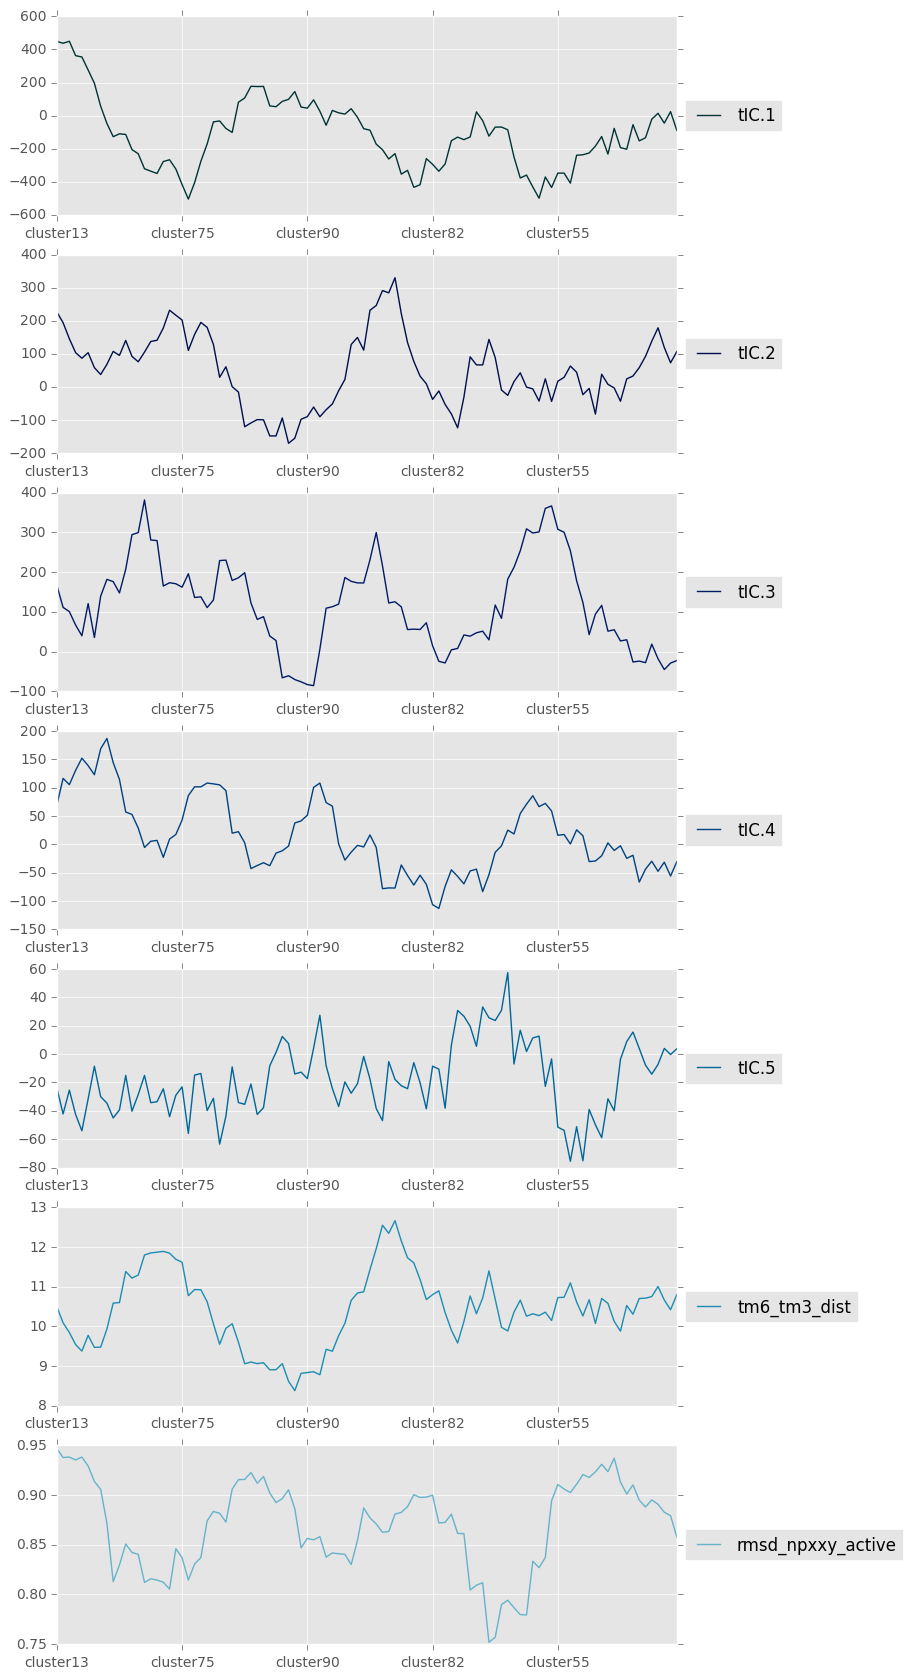

In [107]:
plot_df_rolling(deltas_tica.loc[importances_df.index][["tIC.1", "tIC.2", "tIC.3", "tIC.4", "tIC.5", "tm6_tm3_dist", "rmsd_npxxy_active"]], "%s/tICA_vs_rfr_importance_arrestin_agonists.pdf" %docking_dir, return_fig=True, subplots=True, smoothing=10, include_original=False)

In [41]:
deltas_tica.loc[pd.DataFrame(rfr.feature_importances_, index=aggregate_docking_msm.index, columns=["RFR Importance"]).sort("RFR Importance", ascending=False, inplace=False).index].iloc[:10]

/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


timolol  isopropylnorsynephrine  Compound_B  Compound_H  \
cluster13  0.208423               -0.108073   -0.307023   -0.004164   
cluster38 -0.419577               -0.452073   -0.653023   -0.723364   
cluster80 -0.865977               -0.526073   -0.893023   -1.093364   
cluster99 -0.703177               -0.421273   -0.905823   -0.756164   
cluster44 -0.143577               -0.952873   -0.204623   -0.292564   
cluster60 -0.109577               -0.538073    0.014577   -0.147364   
cluster94 -0.753977               -0.622473   -0.684623   -0.610564   
cluster77 -0.546377               -0.507273   -0.506223   -0.548964   
cluster16 -0.707910               -0.748140   -0.871040   -1.107014   
cluster39 -0.234777               -0.661673    0.238177   -0.148164   

           labetalol  cimaterol  ethylnorepinephrine  s-carazolol  fenoterol  \
cluster13   0.144006   0.166989            -0.395284     0.139517   0.090016   
cluster38  -0.601194  -0.513411            -0.460084    -0.400883  -0.412384   
cluster80  -1.121594  -0.683011            -0.628084    -0.932083  -1.333984   
cluster99  -0.641194  -0.514211            -0.362484    -0.640883  -0.519984   
cluster44  -0.313994  -0.826611            -0.880484    -0.049283  -0.884384   
cluster60  -0.283594  -0.551811            -0.438884    -0.012083  -0.391984   
cluster94  -0.813194  -0.873011            -0.859284    -0.621283  -1.017584   
cluster77  -0.773994  -0.717411            -0.923284    -0.662483  -0.959984   
cluster16  -1.075577  -0.738194            -0.732917    -0.819216  -0.783067   
cluster39  -0.204394  -0.461011            -0.666484    -0.093683  -0.599184   

           pindolol  formoterol   du28663  Compound_E  Ici215001  s-atenolol  \
cluster13 -0.320261   -0.054782 -0.066601   -0.079842   0.198771     0.19941   
cluster38 -0.269061   -0.593982 -0.556601   -0.625442  -0.534029    -0.43059   
cluster80 -0.711461   -0.865182 -0.729001   -1.021842  -1.130429    -0.75859   
cluster99 -0.740661   -0.897982 -0.699001   -0.904242  -0.512429    -0.80379   
cluster44 -0.207061   -0.225982 -0.790201   -0.390242  -0.005229    -0.12139   
cluster60  0.079339   -0.099982 -0.527801   -0.160242  -0.040029    -0.31299   
cluster94 -0.654261   -0.490782 -0.755001   -0.682242  -0.415229    -0.62539   
cluster77 -0.713461   -0.907982 -1.062201   -0.376242  -0.403229    -0.70979   
cluster16 -0.894128   -1.017132 -0.773567   -1.071275  -0.872663    -0.72319   
cluster39  0.126539   -0.645982 -0.463001   -0.225442  -0.214029    -0.20539   

            sotalol  pronethalol  Tulobuterol  practolol  ritrodine  \
cluster13  0.087643     0.244781     0.001920   0.079663   0.326927   
cluster38 -0.406757    -0.489619    -0.659280  -0.383537  -0.619473   
cluster80 -0.916357    -0.951219    -0.772480  -0.775137  -0.875873   
cluster99 -0.880757    -0.816419    -0.718480  -0.239137  -0.704273   
cluster44 -0.203557     0.165581    -0.568480  -0.112337  -0.946273   
cluster60 -0.485157    -0.111219    -0.474880  -0.205937  -0.825073   
cluster94 -0.529557    -0.422019    -0.516880  -0.492337  -0.726673   
cluster77 -0.727957    -0.288019    -0.488080  -0.684737  -1.124273   
cluster16 -0.840073    -0.942435    -0.847164  -0.388170  -0.977173   
cluster39 -0.556357    -0.350419    -0.467280  -0.106737  -0.760673   

           Ici118551  Carvedilol  Compound_A      MAPE  orciprenaline  \
cluster13   0.084367   -0.063051    0.132153 -0.000575      -0.448672   
cluster38  -0.465633   -0.722651   -0.603447 -0.419775      -0.535072   
cluster80  -1.042033   -1.199451   -1.228247 -0.622575      -0.678672   
cluster99  -0.578433   -0.890651   -0.868247 -0.566575      -0.331472   
cluster44  -0.018433    0.306149   -0.183047 -0.608175      -1.001072   
cluster60  -0.136033   -0.043851   -0.235847 -0.295375      -0.428272   
cluster94  -0.287633   -0.582251   -0.586647 -0.511375      -0.863872   
cluster77  -0.394433   -0.532651   -0.549047 -0.356975      -1.106272   
cluster16  -0.879900   -1.099

In [454]:
deltas_tica.sort("nebivolol").iloc[0:10]

timolol  isopropylnorsynephrine  Compound_B  Compound_H  \
cluster78 -0.695577               -0.651273   -1.033423   -1.143364   
cluster80 -0.865977               -0.526073   -0.893023   -1.093364   
cluster16 -0.707910               -0.748140   -0.871040   -1.107014   
cluster74 -0.718777               -0.352073   -0.955823   -1.056164   
cluster26 -0.518777               -0.498873   -1.081023   -1.068964   
cluster51 -0.122377                0.168727   -0.115423   -0.144564   
cluster99 -0.703177               -0.421273   -0.905823   -0.756164   
cluster0  -0.690777               -0.831673   -0.641423   -0.908164   
cluster84 -0.525977               -0.354873   -0.859423   -0.424164   
cluster49 -0.427977               -0.811673   -0.665823   -0.895364   

           labetalol  cimaterol  ethylnorepinephrine  s-carazolol  fenoterol  \
cluster78  -1.309994  -0.955811            -0.703684    -0.796083  -1.403984   
cluster80  -1.121594  -0.683011            -0.628084    -0.932083  -1.333984   
cluster16  -1.075577  -0.738194            -0.732917    -0.819216  -0.783067   
cluster74  -1.179594   0.032989            -0.004884    -0.482883  -0.678384   
cluster26  -0.956394  -0.518611            -0.624084    -0.294483  -0.843984   
cluster51  -0.383594  -0.034211            -0.195284    -0.467283  -0.159584   
cluster99  -0.641194  -0.514211            -0.362484    -0.640883  -0.519984   
cluster0   -1.331594  -0.892211            -0.717284    -0.805283  -1.425184   
cluster84  -0.792794  -0.226211            -0.392484    -0.638483  -0.793984   
cluster49  -0.937994  -0.758211            -0.604884    -0.634083  -1.063184   

           pindolol  formoterol   du28663  Compound_E  Ici215001  s-atenolol  \
cluster78 -0.768661   -1.572782 -0.667001   -1.115042  -0.868429    -0.99739   
cluster80 -0.711461   -0.865182 -0.729001   -1.021842  -1.130429    -0.75859   
cluster16 -0.894128   -1.017132 -0.773567   -1.071275  -0.872663    -0.72319   
cluster74 -0.204261   -0.817982 -0.765001   -0.911042  -0.466029    -0.27059   
cluster26 -0.643461   -1.021182 -0.579801   -1.019042  -0.806829    -0.13299   
cluster51 -0.115861   -0.443982 -0.225401   -0.056242  -0.305229     0.02461   
cluster99 -0.740661   -0.897982 -0.699001   -0.904242  -0.512429    -0.80379   
cluster0  -0.931861   -1.288782 -1.032601   -0.981442  -0.734429    -0.99699   
cluster84 -0.738661   -0.797982 -0.689401   -0.706642  -0.523629    -0.94699   
cluster49 -0.615061   -1.103182 -0.980601   -0.558242  -0.614429    -0.85659   

            sotalol  pronethalol  Tulobuterol  practolol  ritrodine  \
cluster78 -1.273157    -0.776419    -0.962480  -0.955137  -1.207473   
cluster80 -0.916357    -0.951219    -0.772480  -0.775137  -0.875873   
cluster16 -0.840073    -0.942435    -0.847164  -0.388170  -0.977173   
cluster74 -0.421957    -0.576819    -0.605680  -0.278737  -0.641073   
cluster26 -0.533557    -1.141219    -0.764880  -0.213137  -0.737473   
cluster51 -0.302357    -0.395619    -0.031280  -0.361537   0.024927   
cluster99 -0.880757    -0.816419    -0.718480  -0.239137  -0.704273   
cluster0  -0.996757    -0.708019    -0.950080  -0.801137  -1.041873   
cluster84 -0.651957    -0.683619    -0.626880  -0.583137  -0.655473   
cluster49 -0.833957    -0.495619    -0.801280  -0.615137  -1.259073   

           Ici118551  Carvedilol  Compound_A      MAPE  orciprenaline  \
cluster78  -0.717633   -0.936651   -1.287047 -0.707775      -1.001472   
cluster80  -1.042033   -1.199451   -1.228247 -0.622575      -0.678672   
cluster16  -0.879900   -1.099885   -1.079597 -0.683858      -0.648905   
cluster74  -0.811633   -1.038651   -0.730247 -0.274575      -0.673072   
cluster26  -0.676433   -0.604251   -0.735447 -0.648975      -0.710272   
cluster51  -0.629233   -0.388251   -0.369847 -0.130175       0.118128   
cluster99  -0.578433   -0.890651   -0.868247 -0.566575      -0.331472   
cluster0   -0.890033   -0.873451   -0.948647 -0.677775      -0.883072   
cluster84  -0.658433   -0.973

In [446]:
biased_antagonist_indices

{16, 49, 80, 84, 87}

In [467]:
X = delta_delta_g[common_ligands].values.T
print(np.shape(X))
y = bret["Unnamed: 8"].loc[common_ligands].values.reshape((-1,1))
print(np.shape(y))
X_train = X[:30,:]
y_train = y[:30,:]
X_test = X[30:,:]
y_test = y[30:,:]
rfr.fit(X_train,y_train)
print(np.sqrt(np.mean(np.square(y_test-rfr.predict(X_test).reshape((-1,1))))))

(42, 100)
(42, 1)
0.188549596879


/vspdata/vspcompute/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [495]:
chosen_states = pd.DataFrame.from_dict(chosen_clusters, orient='index', dtype=int)
chosen_states.columns = ["n_occurrences"]
arrestin_biased_states = chosen_states.sort("n_occurrences", ascending=False).index.values[0:20]
print(arrestin_biased_states)
deltas_tica = pd.concat([delta_delta_g, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1)
deltas_tica.loc[arrestin_biased_states]

['cluster49' 'cluster84' 'cluster78' 'cluster74' 'cluster69' 'cluster16'
 'cluster43' 'cluster80' 'cluster92' 'cluster54' 'cluster29' 'cluster53'
 'cluster52' 'cluster51' 'cluster50' 'cluster57' 'cluster56' 'cluster55'
 'cluster83' 'cluster21']


timolol  isopropylnorsynephrine  Compound_B  Compound_H  \
cluster49 -0.427977               -0.811673   -0.665823   -0.895364   
cluster84 -0.525977               -0.354873   -0.859423   -0.424164   
cluster78 -0.695577               -0.651273   -1.033423   -1.143364   
cluster74 -0.718777               -0.352073   -0.955823   -1.056164   
cluster69 -0.865177               -0.964073   -0.819423   -1.100964   
cluster16 -0.707910               -0.748140   -0.871040   -1.107014   
cluster43 -1.155577               -0.519673   -0.798623   -1.251364   
cluster80 -0.865977               -0.526073   -0.893023   -1.093364   
cluster92 -0.567177                0.063127   -0.821423   -0.450964   
cluster54 -0.610777               -0.666073   -0.208623   -0.531364   
cluster29 -0.209577               -1.020873   -0.362223   -0.327764   
cluster53 -0.080377                0.065527    0.172577    0.154236   
cluster52  0.022423                0.175527   -0.335023   -0.010564   
cluster51 -0.122377                0.168727   -0.115423   -0.144564   
cluster50 -0.415977               -0.523673   -0.293823   -0.218564   
cluster57 -0.020777               -0.083673   -0.388623   -0.377764   
cluster56 -0.870377               -0.546473   -0.515823   -0.374964   
cluster55 -0.584777               -0.621673   -0.343023   -0.781364   
cluster83 -0.256377               -0.885673   -0.257023   -0.444164   
cluster21 -0.447577               -0.949673   -0.461423   -0.768164   

           labetalol  cimaterol  ethylnorepinephrine  s-carazolol  fenoterol  \
cluster49  -0.937994  -0.758211            -0.604884    -0.634083  -1.063184   
cluster84  -0.792794  -0.226211            -0.392484    -0.638483  -0.793984   
cluster78  -1.309994  -0.955811            -0.703684    -0.796083  -1.403984   
cluster74  -1.179594   0.032989            -0.004884    -0.482883  -0.678384   
cluster69  -0.937594  -0.654211            -0.726084    -0.383283  -0.979584   
cluster16  -1.075577  -0.738194            -0.732917    -0.819216  -0.783067   
cluster43  -0.868794  -0.394211            -0.581284    -0.802883  -0.615584   
cluster80  -1.121594  -0.683011            -0.628084    -0.932083  -1.333984   
cluster92  -0.410394  -0.093811            -0.138084    -0.725683   0.144016   
cluster54  -0.357994  -0.887811            -0.629684    -0.180883  -0.661584   
cluster29  -0.453194  -0.822611            -0.498484    -0.544083  -0.580784   
cluster53  -0.079194  -0.016211            -0.067684     0.483517  -0.009584   
cluster52  -0.329994   0.276189             0.109516     0.147517  -0.037184   
cluster51  -0.383594  -0.034211            -0.195284    -0.467283  -0.159584   
cluster50  -0.538394  -0.467011            -0.297684    -0.315283  -0.479584   
cluster57  -0.528394  -0.169011            -0.359684    -0.203683  -0.539584   
cluster56  -0.363594  -0.723411            -0.429684    -0.744483  -0.416384   
cluster55  -0.737994  -0.720211            -0.618884    -0.634483  -0.973984   
cluster83  -0.230394  -0.753811            -0.519284     0.231917  -0.438784   
cluster21  -0.872794  -0.893811            -0.782884    -0.358483  -1.069984   

           pindolol  formoterol   du28663  Compound_E  Ici215001  s-atenolol  \
cluster49 -0.615061   -1.103182 -0.980601   -0.558242  -0.614429    -0.85659   
cluster84 -0.738661   -0.797982 -0.689401   -0.706642  -0.523629    -0.94699   
cluster78 -0.768661   -1.572782 -0.667001   -1.115042  -0.868429    -0.99739   
cluster74 -0.204261   -0.817982 -0.765001   -0.911042  -0.466029    -0.27059   
cluster69 -0.573461   -0.758782 -0.440601   -1.324642  -0.502029    -0.67859   
cluster16 -0.894128   -1.017132 -0.773567   -1.071275  -0.872663    -0.72319   
cluster43 -0.319461   -0.729582 -0.343801   -1.269842  -0.639229    -0.39779   
cluster80 -0.711461   -0.865182 -0.729001   -1.021842  -1.130429    -0.75859   
cluster92 -0.593061   -0.587182 -0.134201   -0.785842  -0.482829    -0.56259   
cluster54 -0.169861   -0.304382 -0.4234

In [496]:
processed = pd.DataFrame(np.array([np.mean(experiments.values,axis=0), np.std(experiments.values, axis=0)]).T, columns=["means", "stds"])
#results["means"] = experiments.values
#results["stds"] = np.std(experiments.values, axis=0)
processed.index = experiments.columns.values

In [497]:
processed.sort("means", ascending=False)

means      stds
s-carvedilol               3.734594  0.682518
nebivolol                  3.293325  0.516048
Carvedilol                 3.239161  0.520917
Compound_A                 2.556930  0.322773
Compound_E                 2.537464  0.375833
Compound_D                 2.443621  0.341091
alprenalol                 2.415200  0.336701
Ici118551                  2.342203  0.280033
Compound_H                 2.334362  0.268681
formoterol                 2.306021  0.309272
Compound_G                 2.264446  0.280719
Compound_B                 2.259019  0.355700
propranolol                2.231070  0.224151
hexoprenaline              2.182134  0.372778
labetalol                  2.172914  0.223572
s-atenolol                 2.168960  0.241721
Compound_F                 2.162788  0.336219
Xamoterol                  2.119622  0.310642
Compound_C                 2.058959  0.322684
pronethalol                2.040283  0.209455
pindolol                   2.016646  0.250759
bisoprolol                 1.945364  0.285739
Ici215001                  1.916267  0.253819
xamoterol                  1.887941  0.236876
dobutamine                 1.878103  0.186127
s-carazolol                1.833410  0.314849
fenoterol                  1.775932  0.203310
sotalol                    1.774926  0.227975
cgp12177                   1.737071  0.270938
ritrodine                  1.689253  0.194887
practolol                  1.681288  0.209104
Compound_J                 1.680063  0.245853
3p0g_lig                   1.629387  0.210615
salmeterol                 1.568480  0.250798
salbutamol                 1.531134  0.133081
Compound_I                 1.511011  0.156509
nor-metanephrine           1.507234  0.130782
du28663                    1.506478  0.152997
Tulobuterol                1.416214  0.115744
timolol                    1.409856  0.163096
epinine                    1.361143  0.118777
Ici89406                   1.335202  0.243271
MAPE                       1.333888  0.107017
dichloroisopreterenol      1.293484  0.116818
N-Cyclopentylbutanephrine  1.275746  0.101389
orciprenaline              1.266372  0.096994
ethylnorepinephrine        1.252837  0.108371
TERBSN                     1.252073  0.077752
dopamine                   1.244952  0.116737
isoetharine                1.237662  0.105270
clenproperol               1.209225  0.112054
isopropylnorsynephrine     1.197740  0.069554
adrenalone                 1.195653  0.098671
terbutaline                1.184523  0.102480
clenbuterol                1.176704  0.110354
r_epinephrine              1.120631  0.081516
cimaterol                  1.047371  0.082271
skf42469                   1.013625  0.098362
r_isopreterenol            1.000000  0.000000
ta-2005                    0.988810  0.152943
norepinephrine             0.985835  0.081284
du211117                   0.984433  0.068746
procaterol                 0.855757  0.103037
sulfonterol                0.651116  0.066789

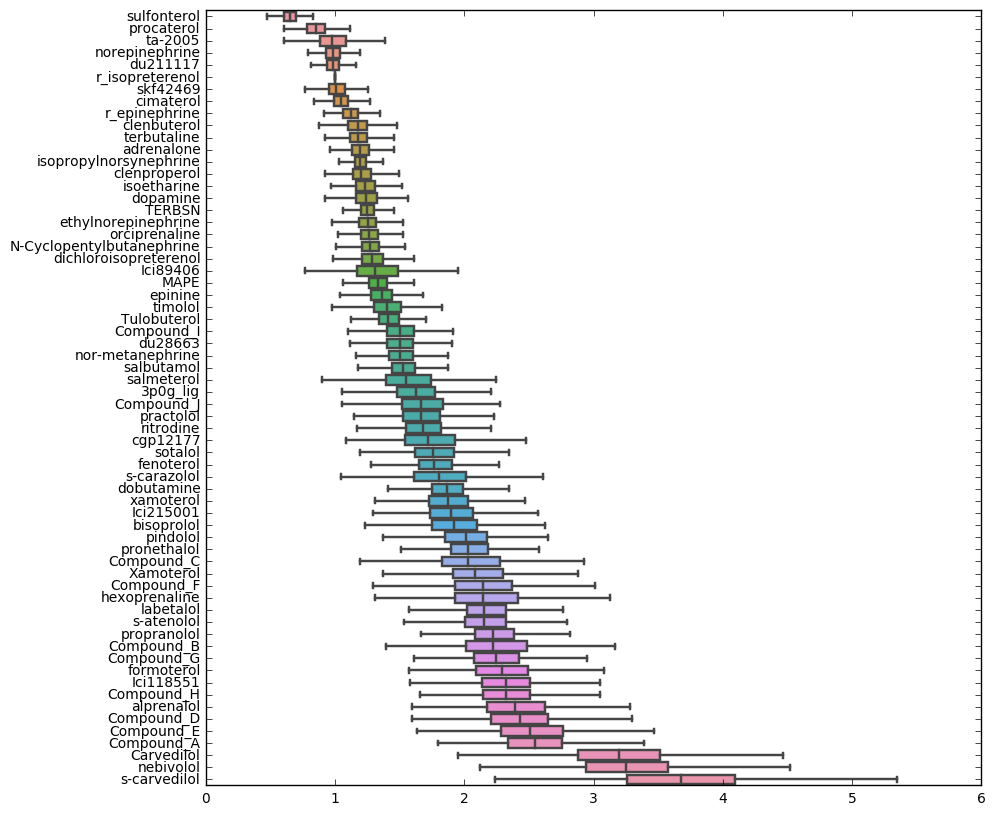

In [499]:
import seaborn
reload(seaborn)
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
experiments_sorted = experiments[experiments.median().order().index.values]
g = (experiments_sorted
    .pipe((sns.boxplot, 'data'), orient='h', showfliers=False))
#g.set_xticklabels(experiments.columns.values, rotation=90)
#sns.despine()
plt.show()

In [1243]:
from sklearn.preprocessing import scale

df_agg = pd.read_csv(aggregate_docking, index_col=0)

df = pd.read_csv(docking_multiple_ligands, index_col=0, skip_blank_lines=True).dropna()
df.dropna(inplace=True)
msm_obj = verboseload(msm_model_dir)

msm_clusters = msm_obj.mapping_.keys()
msm_cluster_names = ["cluster%d" %i for i in msm_clusters]
msm_cluster_eq_pops = []
for cluster_id in msm_clusters:
    state_id = msm_obj.mapping_[cluster_id]
    msm_cluster_eq_pops.append(msm_obj.populations_[state_id])
msm_cluster_eq_pops = np.array(msm_cluster_eq_pops)
msm_cluster_deltaG = -0.61 * np.log(msm_cluster_eq_pops)
msm_cluster_eq_pops_df = pd.DataFrame(msm_cluster_eq_pops, index=msm_cluster_names)
aggregate_docking_msm = df_agg.loc[msm_cluster_names]


new_populations = copy.deepcopy(aggregate_docking_msm)
for ligand in aggregate_docking_msm.columns.values:
    new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.61)

Z = np.sum(new_populations.values, axis=0)
for j, ligand in enumerate(aggregate_docking_msm.columns.values):
    new_populations[ligand] = new_populations[ligand].values / Z[j]
population_deltas = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
new_energies = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    new_energies[ligand] = -.61 * np.log(new_populations[ligand])
delta_delta_g = copy.deepcopy(new_energies)
for ligand in aggregate_docking_msm.columns.values:
    delta_delta_g[ligand] = new_energies[ligand].values - msm_cluster_deltaG

train_biased_antagonists = [" s-carvedilol", " nebivolol", " 3p0g_lig"]
docking_normalized = copy.deepcopy(population_deltas)
docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

agonist_minus_antagonists = deltas_tica[train_agonists].mean(axis=1).values - deltas_tica[train_inverse_agonists + train_biased_antagonists].mean(axis=1).values
agonist_minus_antagonists = (agonist_minus_antagonists - np.mean(agonist_minus_antagonists))/np.std(agonist_minus_antagonists)
agonist_states = deltas_tica.iloc[np.where(agonist_minus_antagonists > 2.0)].loc[docking_normalized[train_agonists].min(axis=1) > 1.]

bias_antagonist_minus_antagonists = deltas_tica[train_biased_antagonists].max(axis=1).values - deltas_tica[train_inverse_agonists].min(axis=1).values
bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)

bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
indices = list(set(np.where(bias_antagonist_minus_antagonists < -.5)[0]))#.tolist()).intersection(set(np.where(bias_antagonist_minus_antagonists > 1.)[0].tolist())))
biased_antagonist_states = deltas_tica.iloc[list(set(indices).intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]


experiments2 = []
n_experiments = 500
for experiment in range(0, n_experiments):
    docking_rows = []
    docking_ids = []
    for cluster_id in range(0, n_clusters):
        sample_ids = ["cluster%d_sample%d" %(cluster_id, sample_id) for sample_id in range(0,n_samples)]
        samples =  np.random.choice(sample_ids, len(sample_ids), replace=True)
        docking_rows.append(np.mean(df.loc[samples].dropna().values, axis=0))
        docking_ids.append("cluster%d" %cluster_id)
    docking = pd.DataFrame(docking_rows, columns=df.columns.values, index = docking_ids)
    
    aggregate_docking_msm = docking.loc[list(set(msm_cluster_names).intersection(set(docking.index.values)))]
    

    new_populations = copy.deepcopy(aggregate_docking_msm)
    for ligand in aggregate_docking_msm.columns.values:
        new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.61)

    Z = np.sum(new_populations.values, axis=0)
    for j, ligand in enumerate(aggregate_docking_msm.columns.values):
        new_populations[ligand] = new_populations[ligand].values / Z[j]
    population_deltas = copy.deepcopy(new_populations)
    for ligand in aggregate_docking_msm.columns.values:
        population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
    new_energies = copy.deepcopy(new_populations)
    for ligand in aggregate_docking_msm.columns.values:
        new_energies[ligand] = -.61 * np.log(new_populations[ligand])
    delta_delta_g = copy.deepcopy(new_energies)
    for ligand in aggregate_docking_msm.columns.values:
        delta_delta_g[ligand] = new_energies[ligand].values - msm_cluster_deltaG
        
    biased_population = new_populations.loc[biased_antagonist_states.index].sum(axis=0)
    biased_antagonist_ori = msm_cluster_eq_pops_df.loc[biased_antagonist_states.index].sum().values[0]
    biased_antagonist_change = biased_population.divide(biased_antagonist_ori)
    
    experiments2.append(biased_antagonist_change)

experiments2 = pd.DataFrame(experiments2, columns = df.columns.values)



loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_n_clusters100lag_time10.h5"...


KeyError: "[' procaterol '] not in index"